#  **Análise de Assinaturas de Carga Elétrica**
### *Autor:* José Tiago Torres de Lima  
### *Universidade Federal do Ceará (UFC)*

---

##  **Descrição do Projeto**

Neste trabalho, foram coletadas amostras de assinaturas de carga elétrica utilizando um osciloscópio. O objetivo foi validar o sistema de aquisição de dados desenvolvido, comparando os sinais capturados com uma referência confiável.

As medições feitas com o osciloscópio revelam uma **componente constante (DC offset)** presente em todas as amostras, característica importante para calibrar e ajustar o processamento dos dados.

# **Diferenças entre o Sistema Desenvolvido e o Osciloscópio**
O sistema desenvolvido opera com uma taxa de amostragem de 7.500 amostras por segundo (SPS), em contraste com o osciloscópio de referência, que captura 25.000 SPS. Essa diferença confere ao osciloscópio uma resolução temporal superior, habilitando a captura de detalhes mais finos do sinal, especialmente em componentes de frequência elevada. Contudo, uma análise qualitativa revela uma vantagem crucial do sistema proposto: enquanto as amostras do osciloscópio exibem um nível de ruído proeminente, os dados adquiridos pelo sistema customizado são notavelmente limpos e estáveis.

A superioridade do sistema em relação ao ruído é uma consequência direta de sua arquitetura de aquisição. O projeto é centrado em um conversor Analógico-Digital (ADC) de alta resolução (24 bits), especificamente escolhido para aplicações de medição de precisão. Este tipo de conversor, por sua natureza, emprega técnicas de sobreamostragem e filtragem digital para atenuar drasticamente o ruído de quantização na banda de interesse. Adicionalmente, o hardware de aquisição foi projetado para utilizar uma configuração de entrada diferencial, uma escolha de engenharia fundamental para garantir alta rejeição a ruídos de modo comum, como interferências eletromagnéticas externas. Em contrapartida, osciloscópios de uso geral frequentemente utilizam entradas de terminação única (single-ended), que são mais suscetíveis a ruídos e otimizados para velocidade em detrimento da fidelidade do sinal em baixas e médias frequências.

Apesar da menor taxa de amostragem, a frequência de Nyquist do sistema (3.750 Hz) é plenamente suficiente para caracterizar com exatidão as componentes de dispositivos de corrente alternada, como as fundamentais de 50 Hz ou 60 Hz e suas principais harmônicas. O sistema é, portanto, perfeitamente capaz de identificar as características essenciais do sinal, como a frequência fundamental e anomalias nas assinaturas de carga, com a vantagem de fornecer dados de alta fidelidade. A comparação entre os resultados é, assim, válida, e o sistema desenvolvido se afirma como uma ferramenta confiável para o monitoramento e diagnóstico de dispositivos elétricos, apresentando como benefícios adicionais a eficiência e a escalabilidade para medições em larga escala.

Este caderno organiza e apresenta o processo completo, desde o carregamento e tratamento dos dados até a análise nos domínios do tempo e da frequência, culminando na visualização dos resultados através de gráficos de alta qualidade que permitem uma interpretação clara e inequívoca.

# **Lâmpada de Aquecimeto - Osciloscópio**

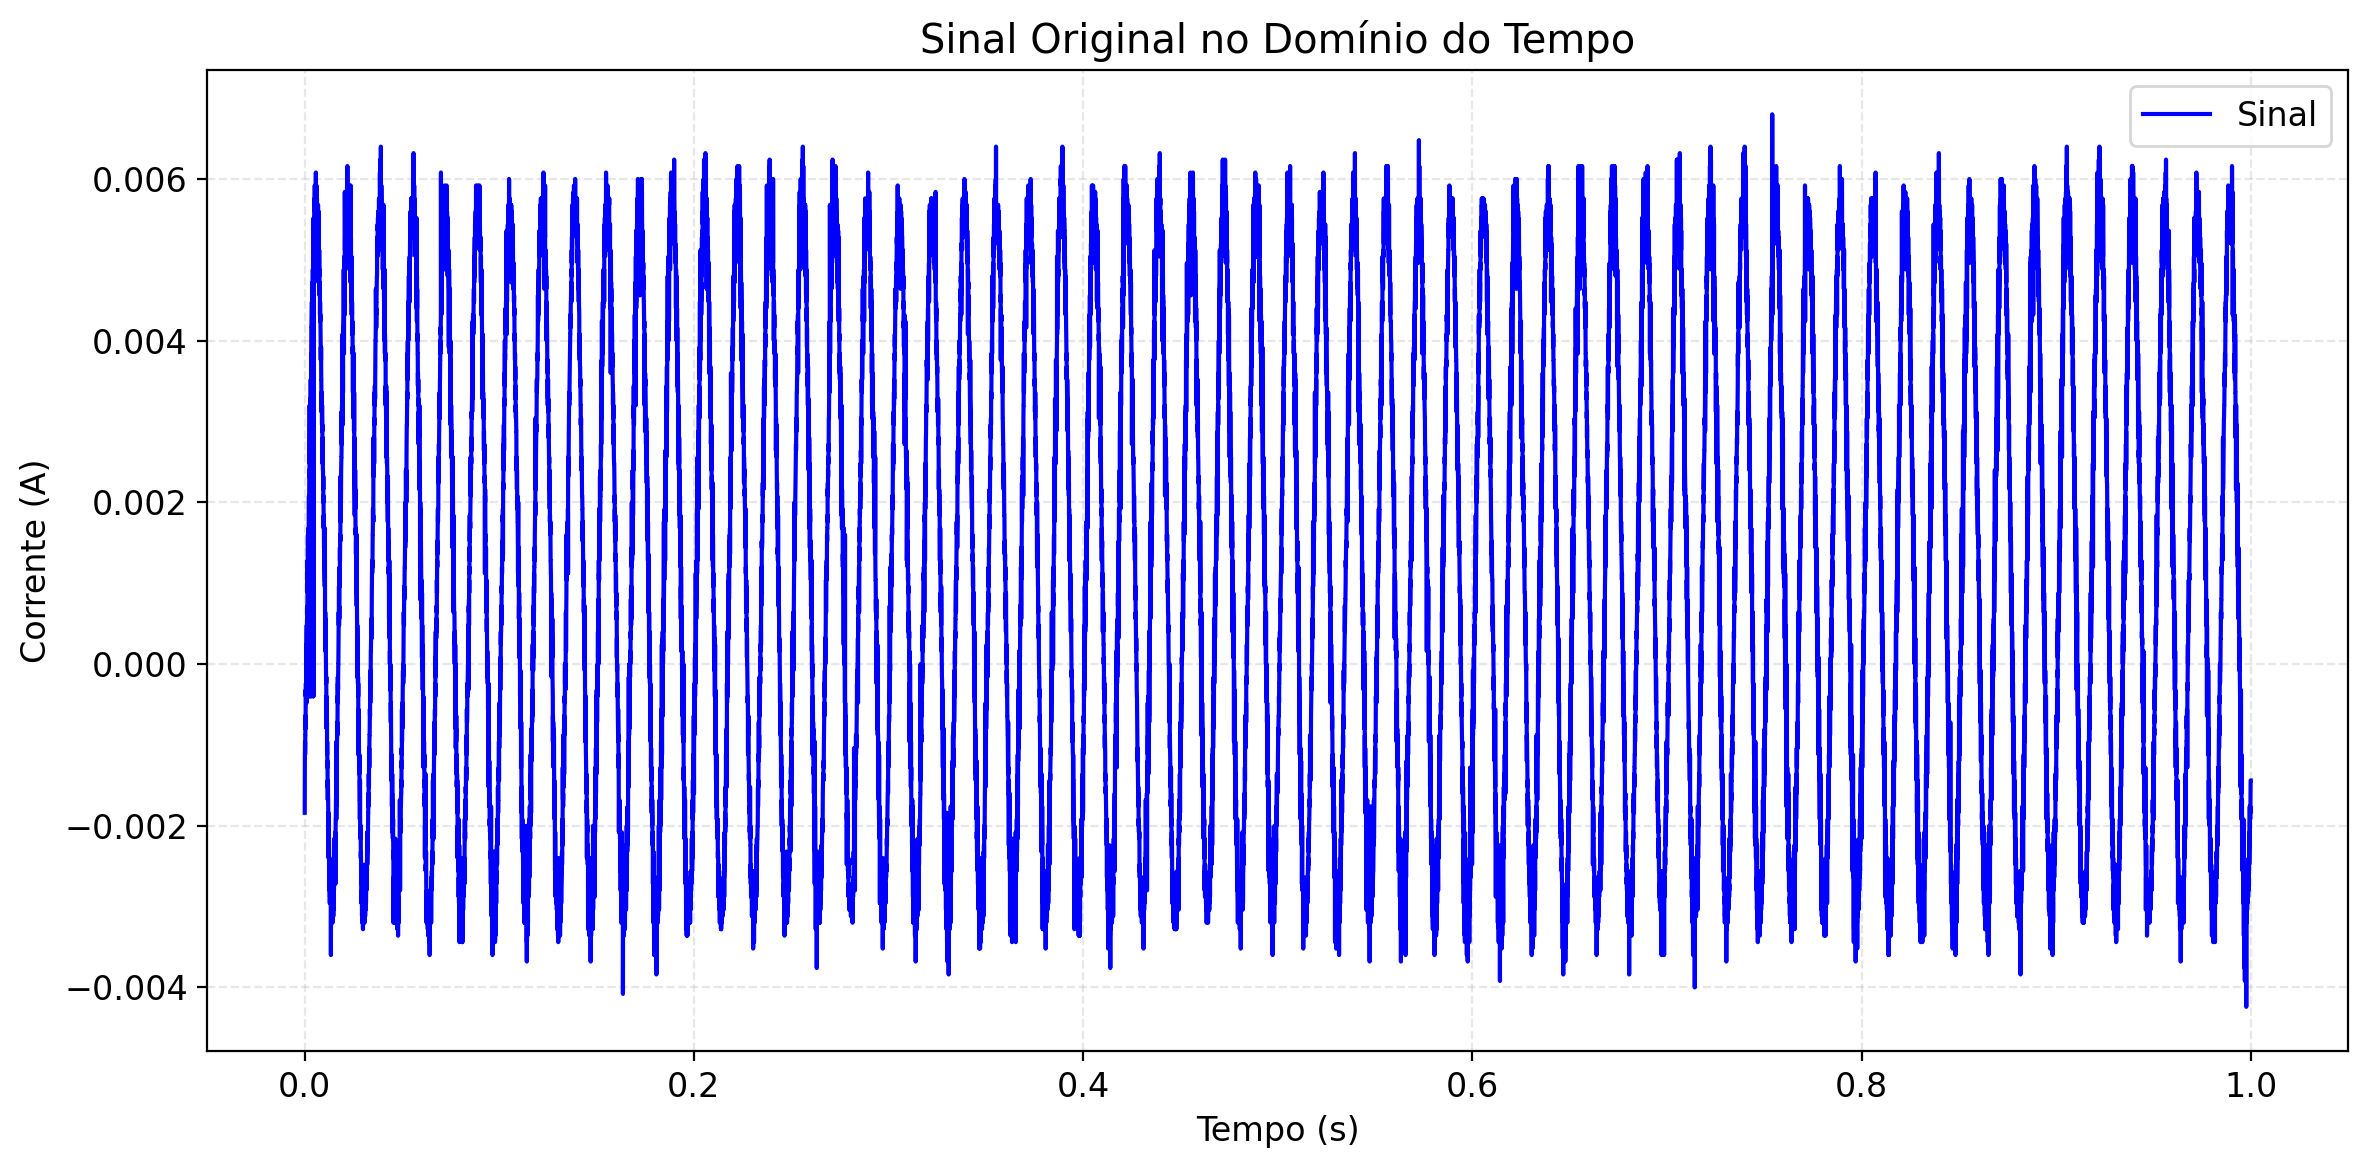

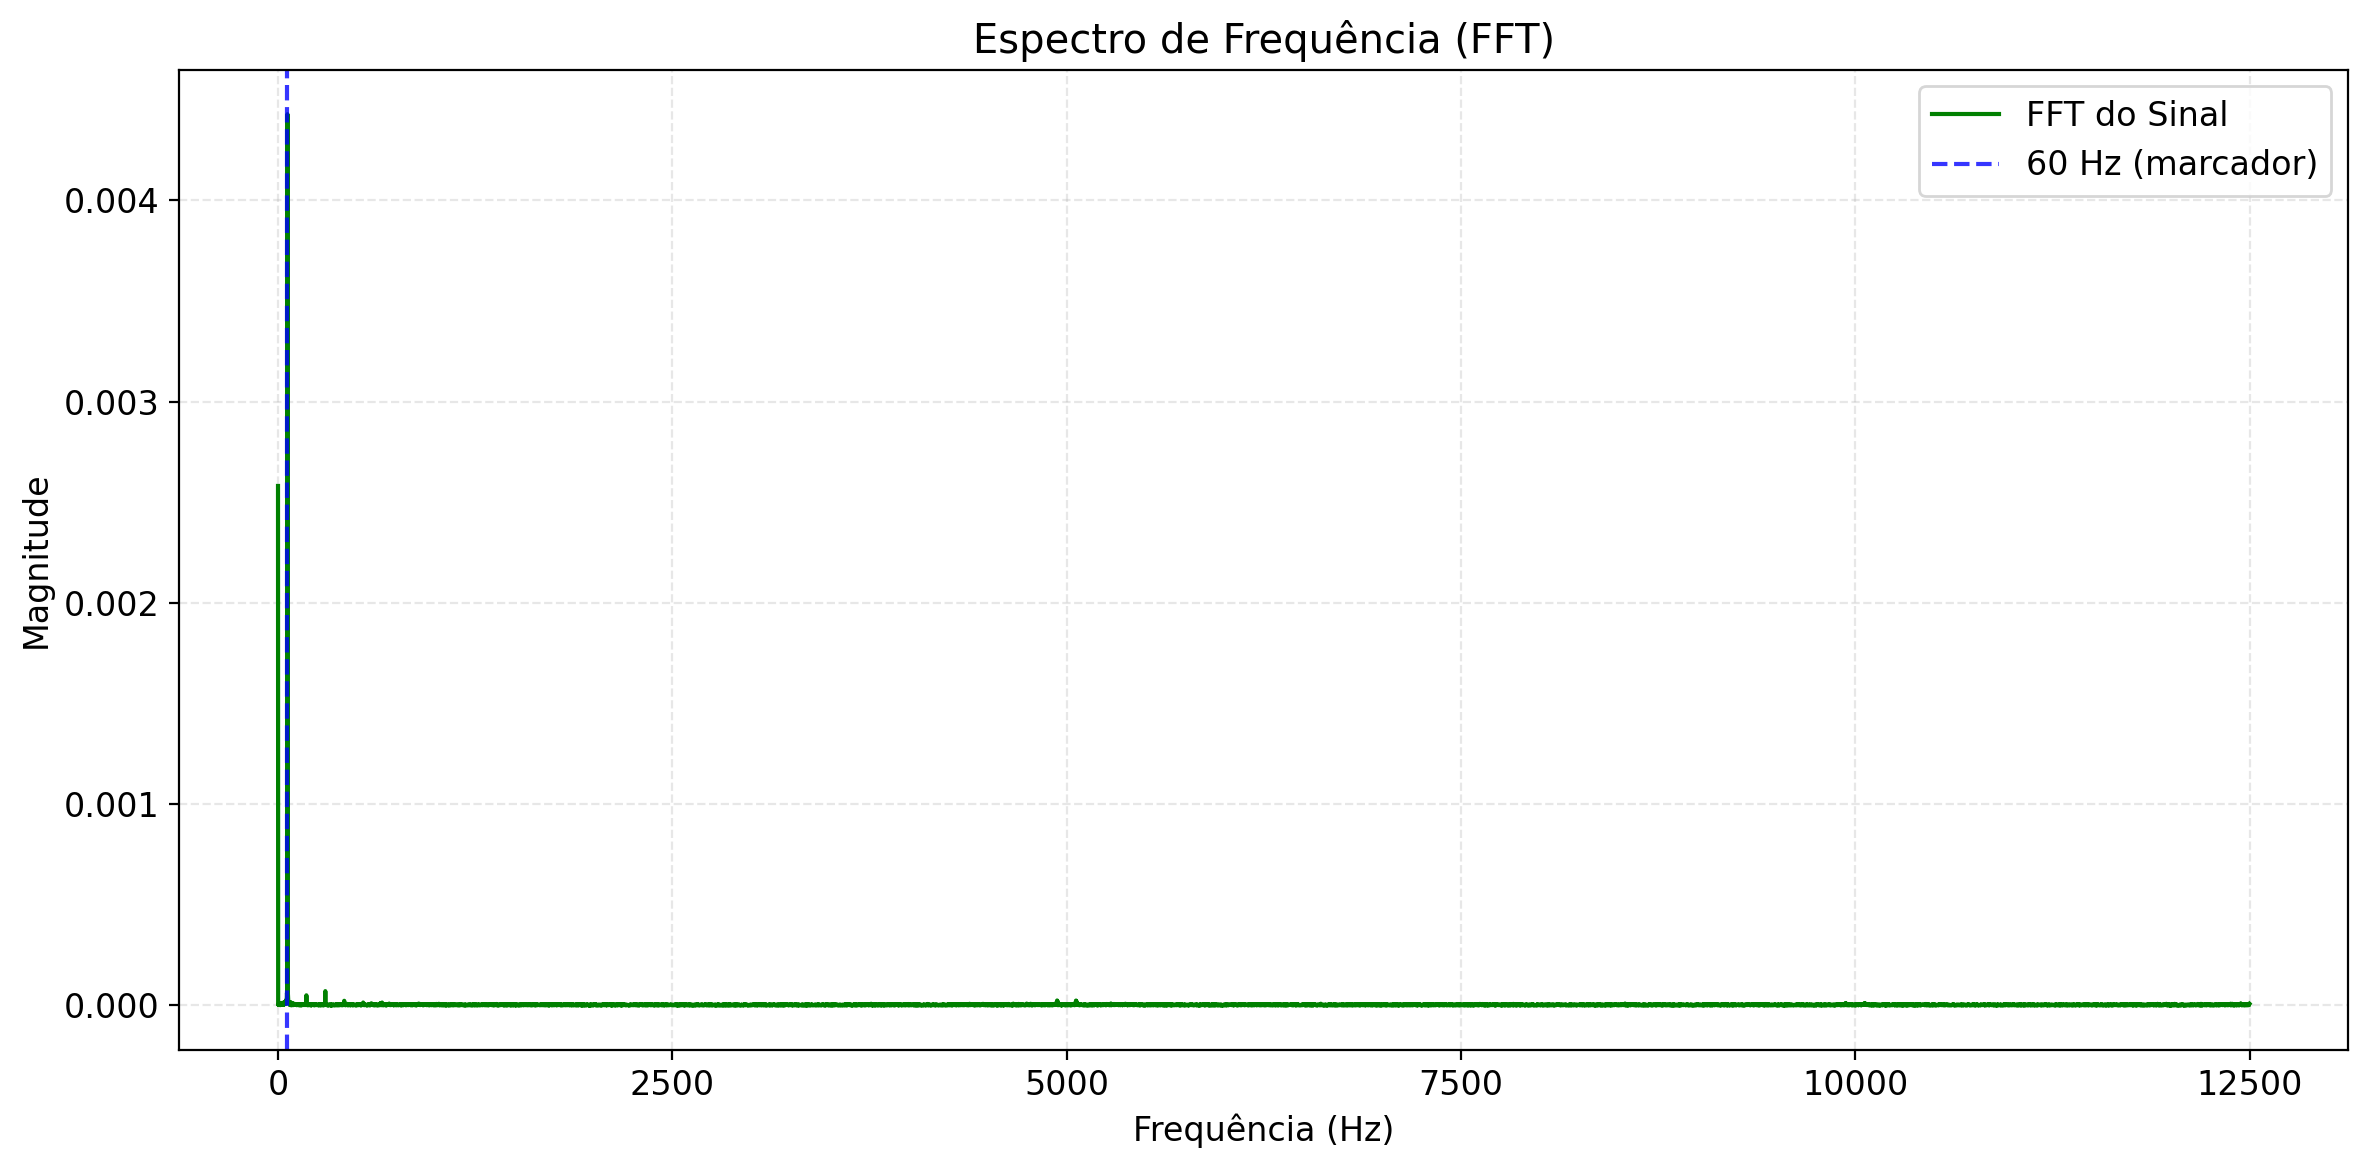

Frequência fundamental detectada: 60.00 Hz


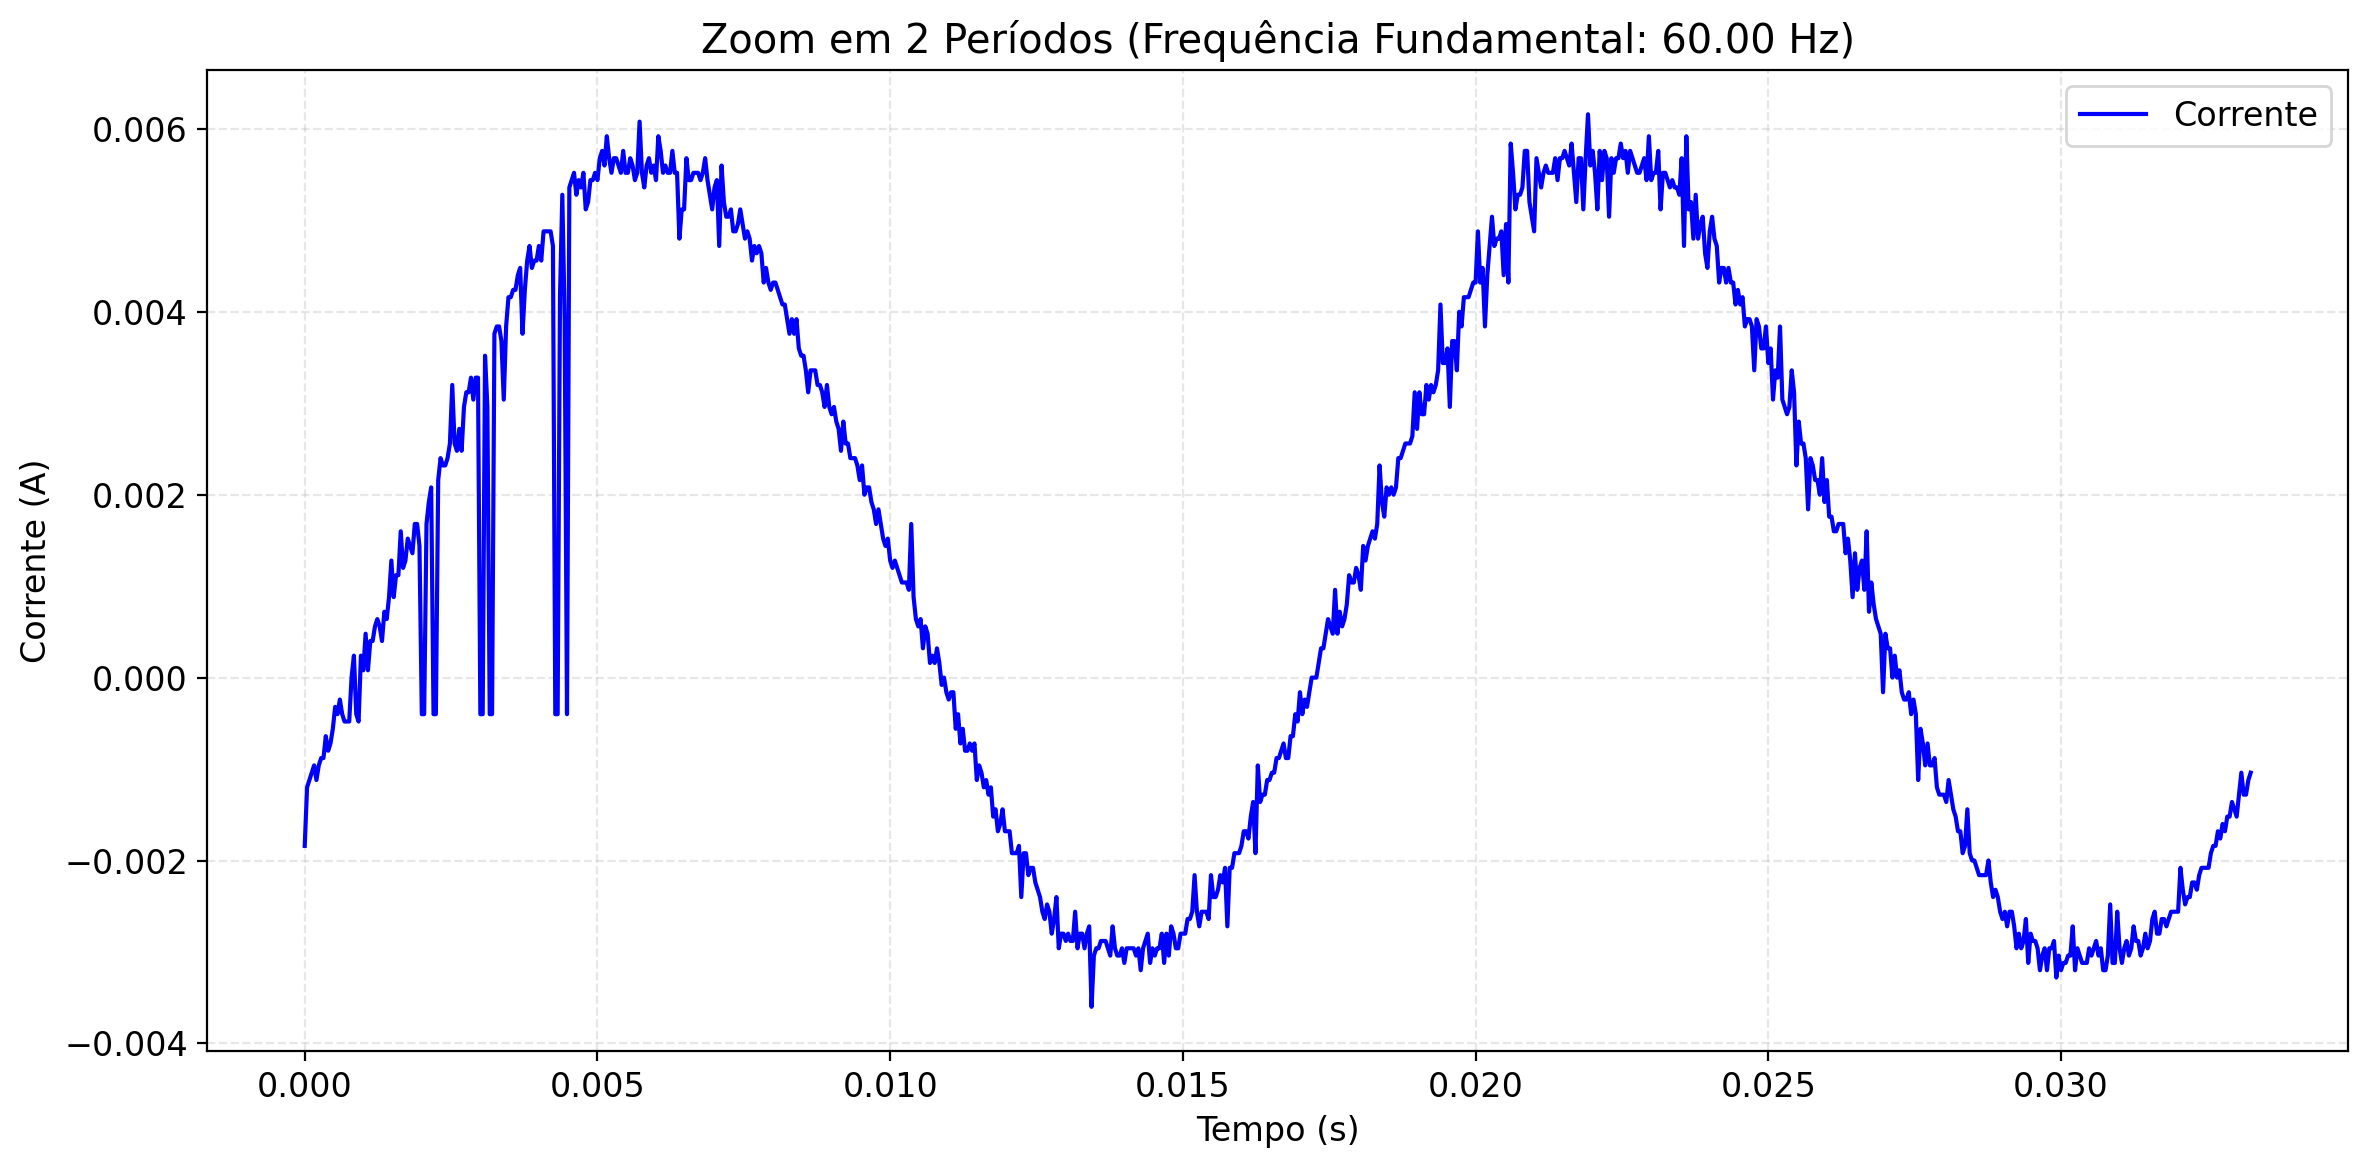

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# --- CONFIGURAÇÃO GLOBAL PARA ALTA QUALIDADE DE PLOTAGEM ---
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# --- 1. CARREGAMENTO E LIMPEZA DOS DADOS ---
caminho_arquivo = "/content/L.CSV"
try:
    df = pd.read_csv(caminho_arquivo, delimiter=",", skiprows=1, names=["Tempo (s)", "Corrente (A)"])
except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado.")
    exit()

df["Tempo (s)"] = pd.to_numeric(df["Tempo (s)"], errors="coerce")
df["Corrente (A)"] = pd.to_numeric(df["Corrente (A)"], errors="coerce")
df = df.dropna().sort_values(by="Tempo (s)")

# --- 2. PREPARAÇÃO PARA ANÁLISE ---
t = df["Tempo (s)"].values
y = df["Corrente (A)"].values

# Ajuste para o gráfico do tempo, começando de 0 se os valores estiverem negativos
t = t - t[0]

# Limitar o sinal a 1 segundo
t_limitado = t[t <= 1]  # Limitar até 1 segundo
y_limitado = y[:len(t_limitado)]  # Manter apenas os dados correspondentes

if len(y_limitado) < 2:
    print("Não há dados suficientes para analisar após a limpeza.")
else:
    # --- 3. CÁLCULO DOS PARÂMETROS DE AMOSTRAGEM E FFT ---
    N = len(y_limitado)
    Ts = np.mean(np.diff(t_limitado))
    fs = 1 / Ts

    yf_complex = fft(y_limitado)
    xf = fftfreq(N, Ts)

    # Limitar a frequência máxima para o gráfico (Nyquist)
    xf_pos = xf[:N // 2]
    yf_mag = 2.0 / N * np.abs(yf_complex[:N // 2])

    # --- 4. DETECÇÃO DA FREQUÊNCIA FUNDAMENTAL ---
    if len(yf_mag) > 1:
        indice_pico = np.argmax(yf_mag[1:]) + 1
        freq_fund = xf_pos[indice_pico]
    else:
        freq_fund = 0

    # --- 5. PLOTAGEM EM FIGURAS SEPARADAS DE ALTA QUALIDADE ---

    # Gráfico 1: Sinal Original no Domínio do Tempo
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(t_limitado, y_limitado, label="Sinal", color="blue", linewidth=1.5)
    plt.title("Sinal Original no Domínio do Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Corrente (A)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Espectro de Frequência (FFT)
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(xf_pos, yf_mag, label="FFT do Sinal", color="green", linewidth=1.5)
    plt.axvline(x=60, color='blue', linestyle='--', alpha=0.79, label='60 Hz (marcador)')
    plt.title("Espectro de Frequência (FFT)")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Definir os ticks no eixo X (frequência)
    xticks = np.arange(0, max(xf_pos), step=2500)  # Ajuste o intervalo conforme necessário
    xticks = np.append(xticks, 12500)  # Adiciona 12500 no final
    plt.xticks(xticks)

    plt.tight_layout()
    plt.show()


    # Gráfico 3: Zoom em 2 Períodos
    if freq_fund > 0:
        print(f"Frequência fundamental detectada: {freq_fund:.2f} Hz")

        amostras_zoom = int(round(2 * fs / freq_fund))
        if amostras_zoom > N:
            amostras_zoom = N

        plt.figure(figsize=(12, 6), dpi=200)
        plt.plot(t_limitado[:amostras_zoom], y_limitado[:amostras_zoom], label="Corrente", color="blue", linewidth=1.5)
        plt.title(f"Zoom em 2 Períodos (Frequência Fundamental: {freq_fund:.2f} Hz)")
        plt.xlabel("Tempo (s)")
        plt.ylabel("Corrente (A)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Não foi possível detectar uma frequência fundamental válida para o zoom.")
        plt.figure(figsize=(12, 3), dpi=200)
        plt.text(0.5, 0.5, 'Zoom não aplicável (frequência fundamental não detectada)',
                 ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# **Lâmpada de Aquecimeto - Sistema Proposto**

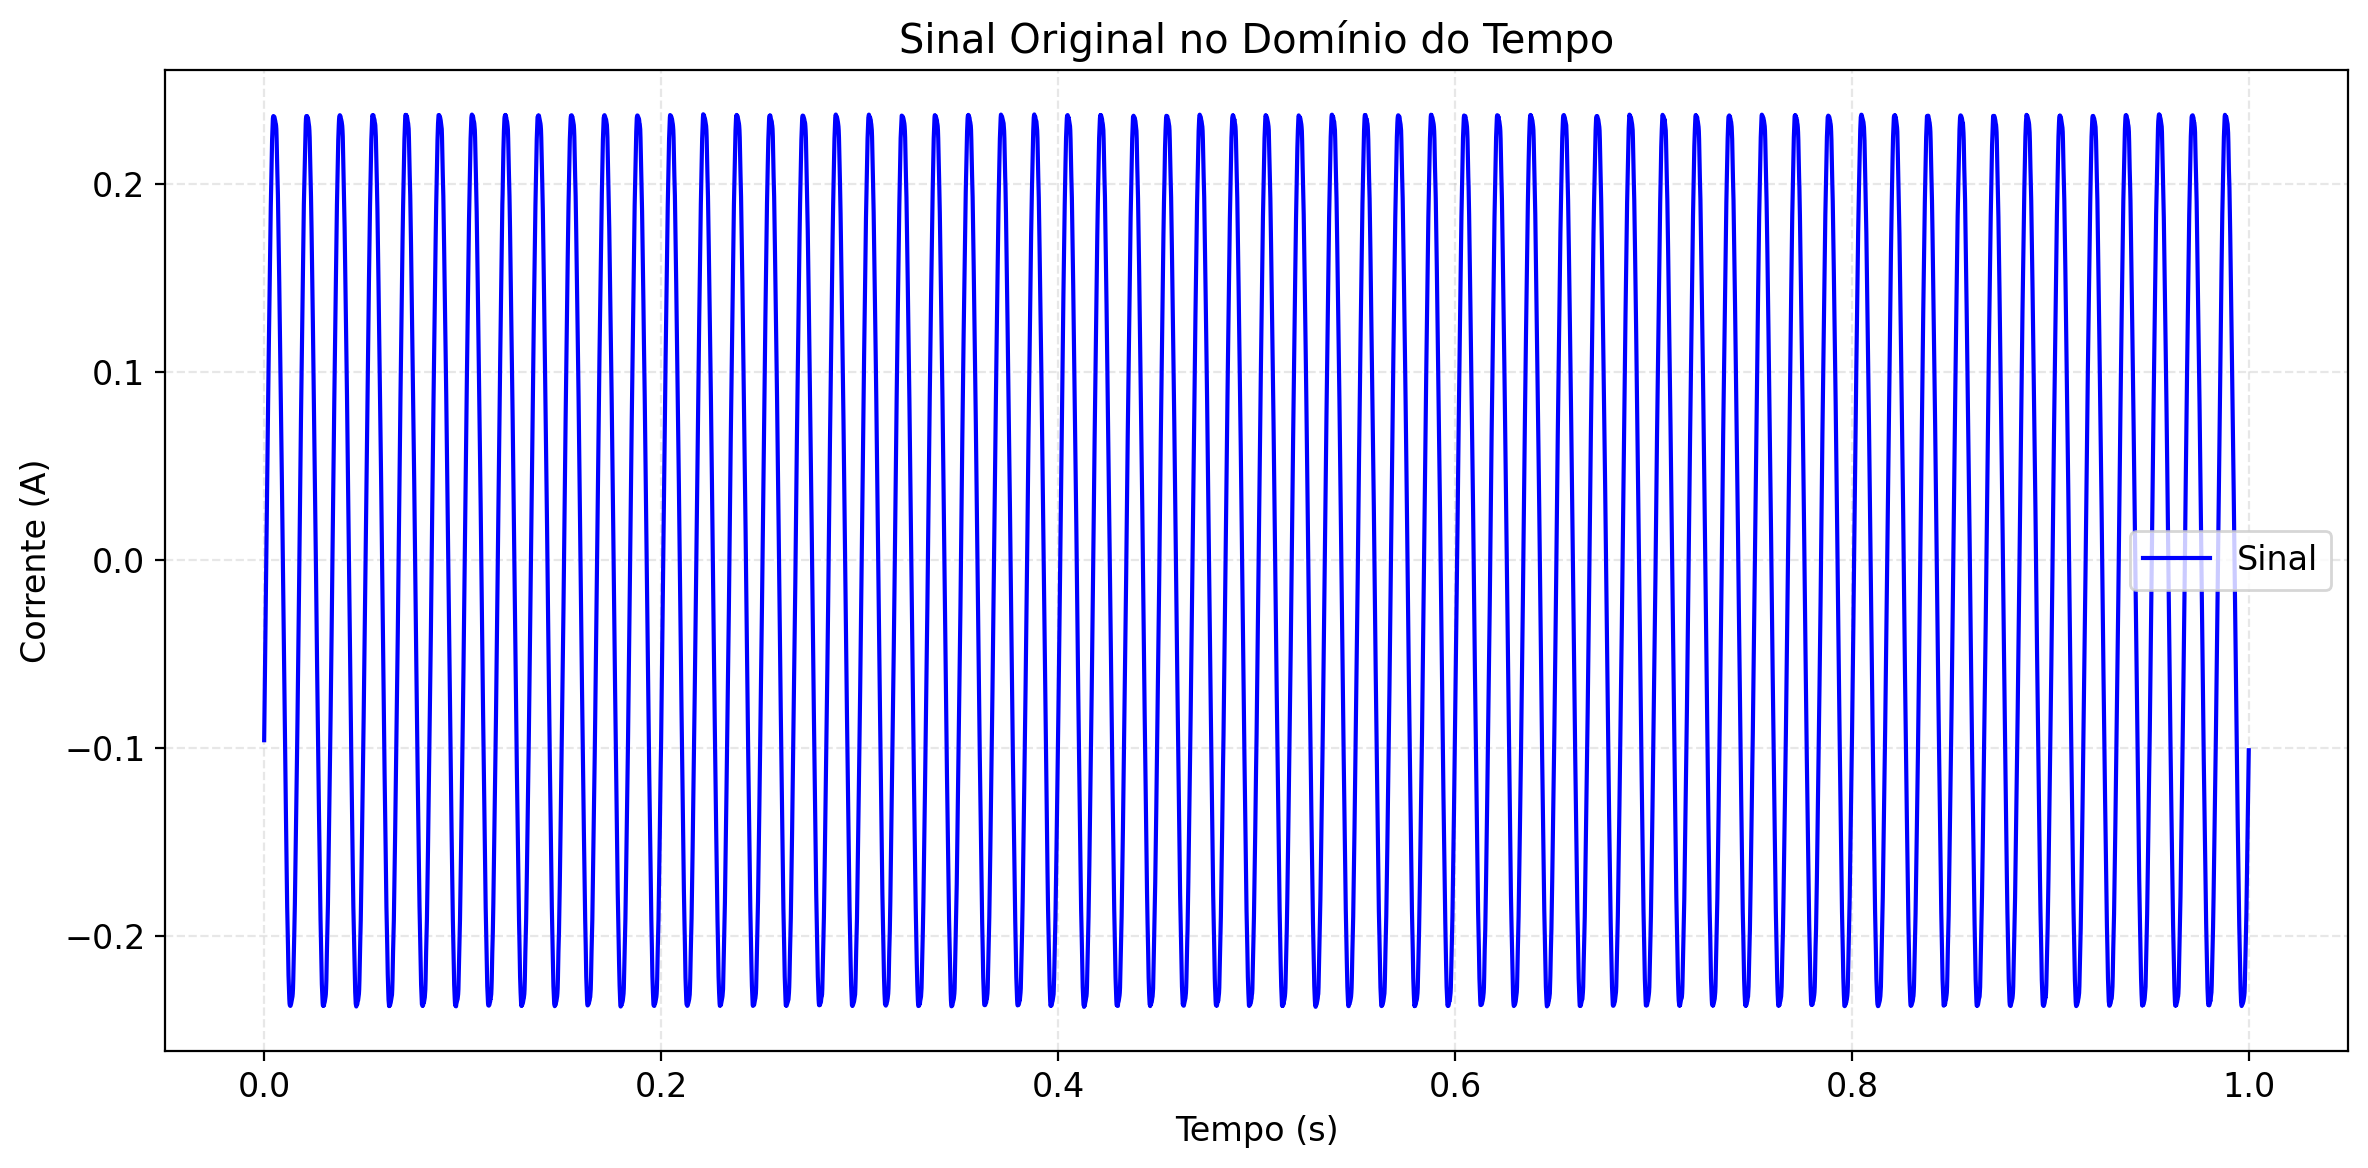

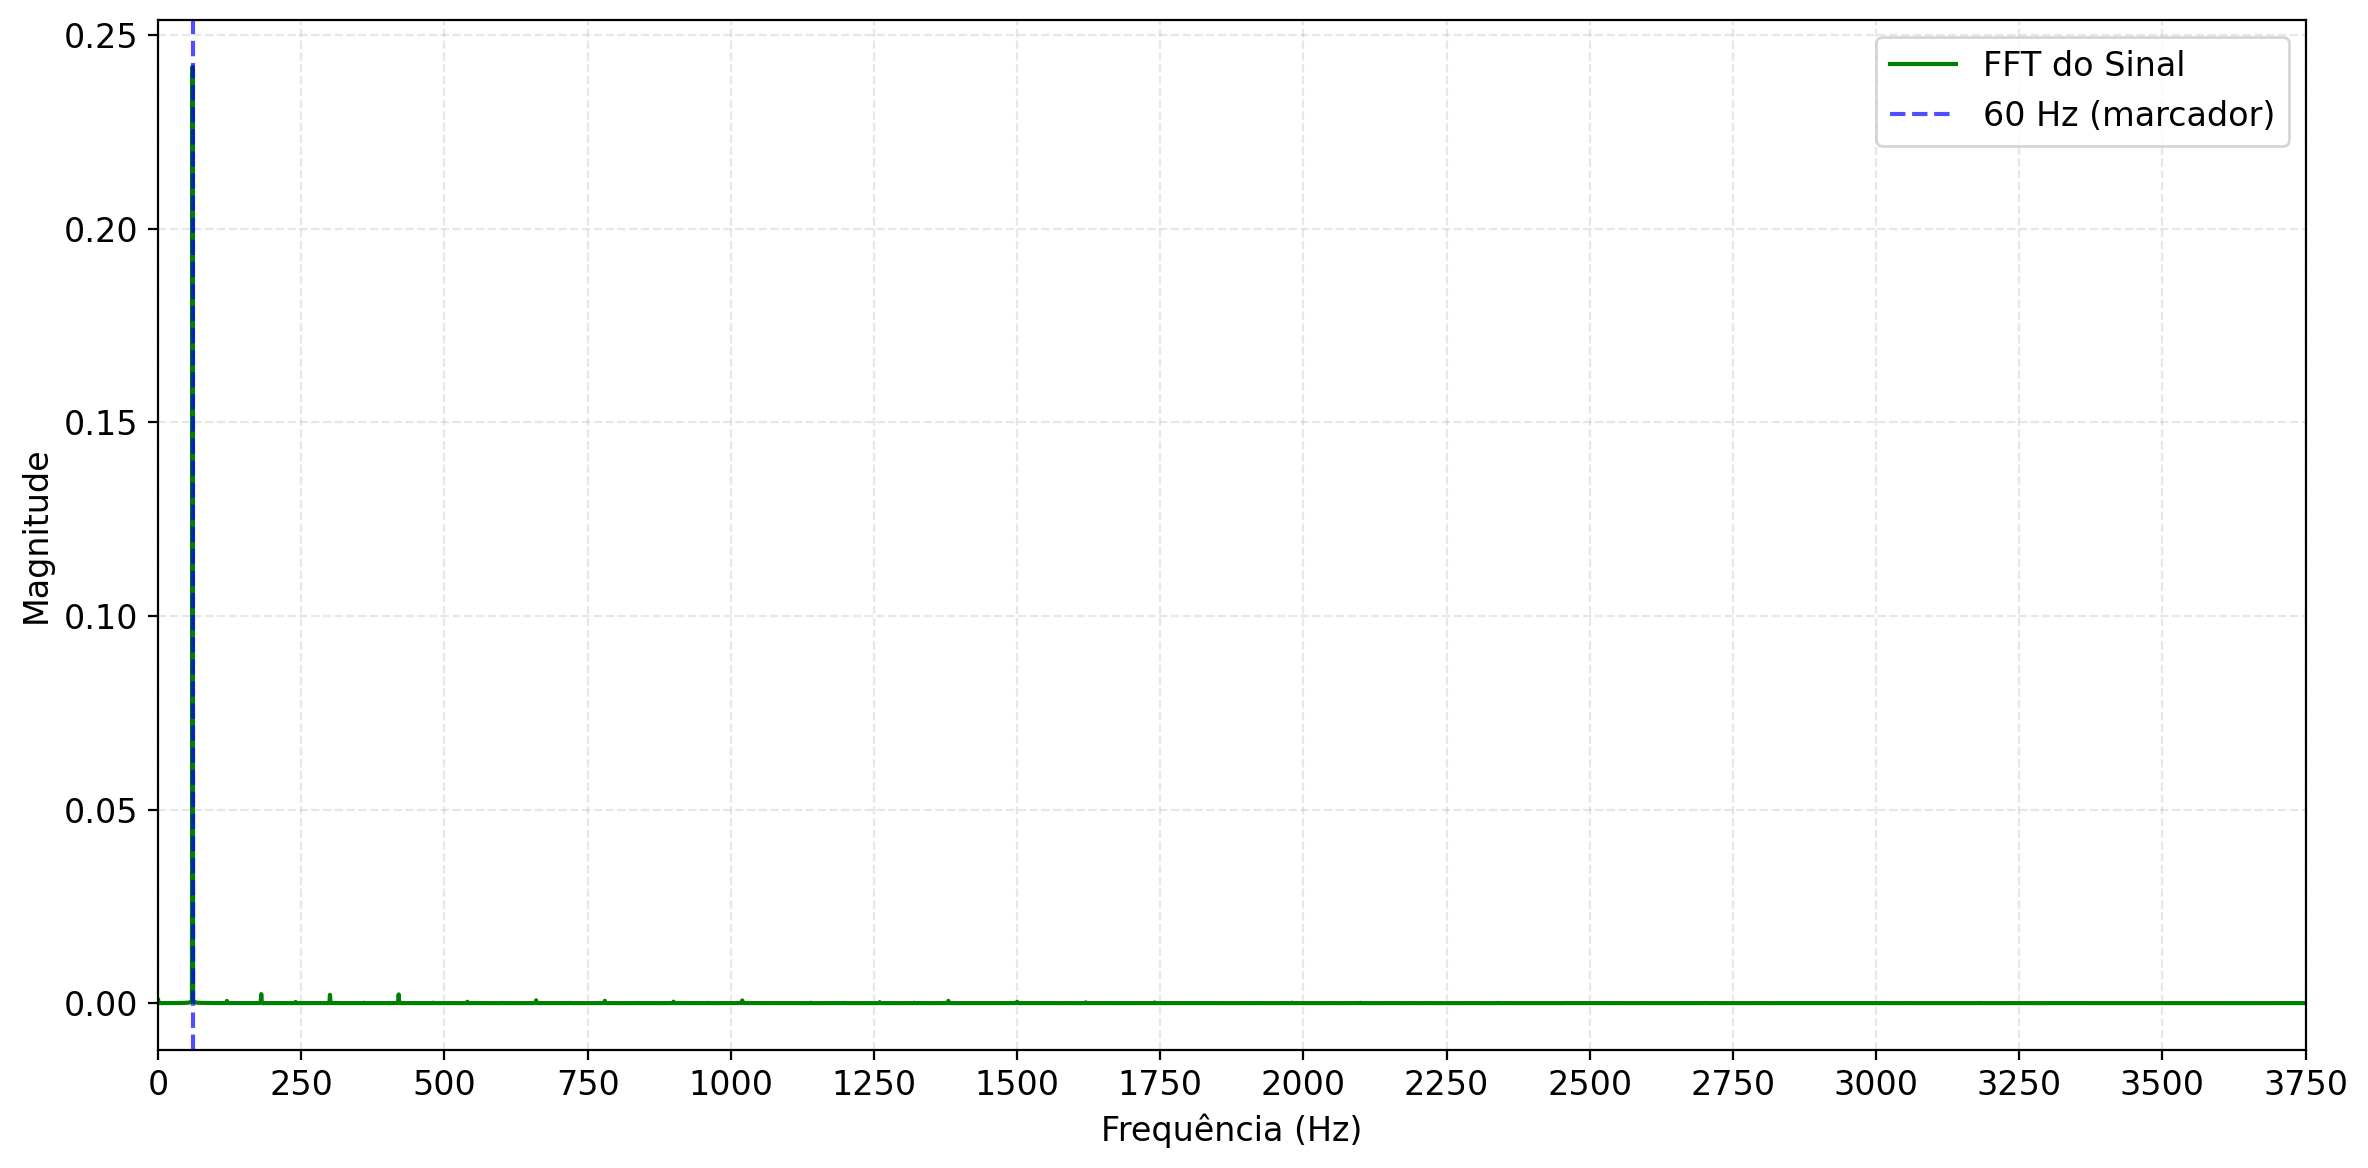

Frequência fundamental detectada: 60.00 Hz


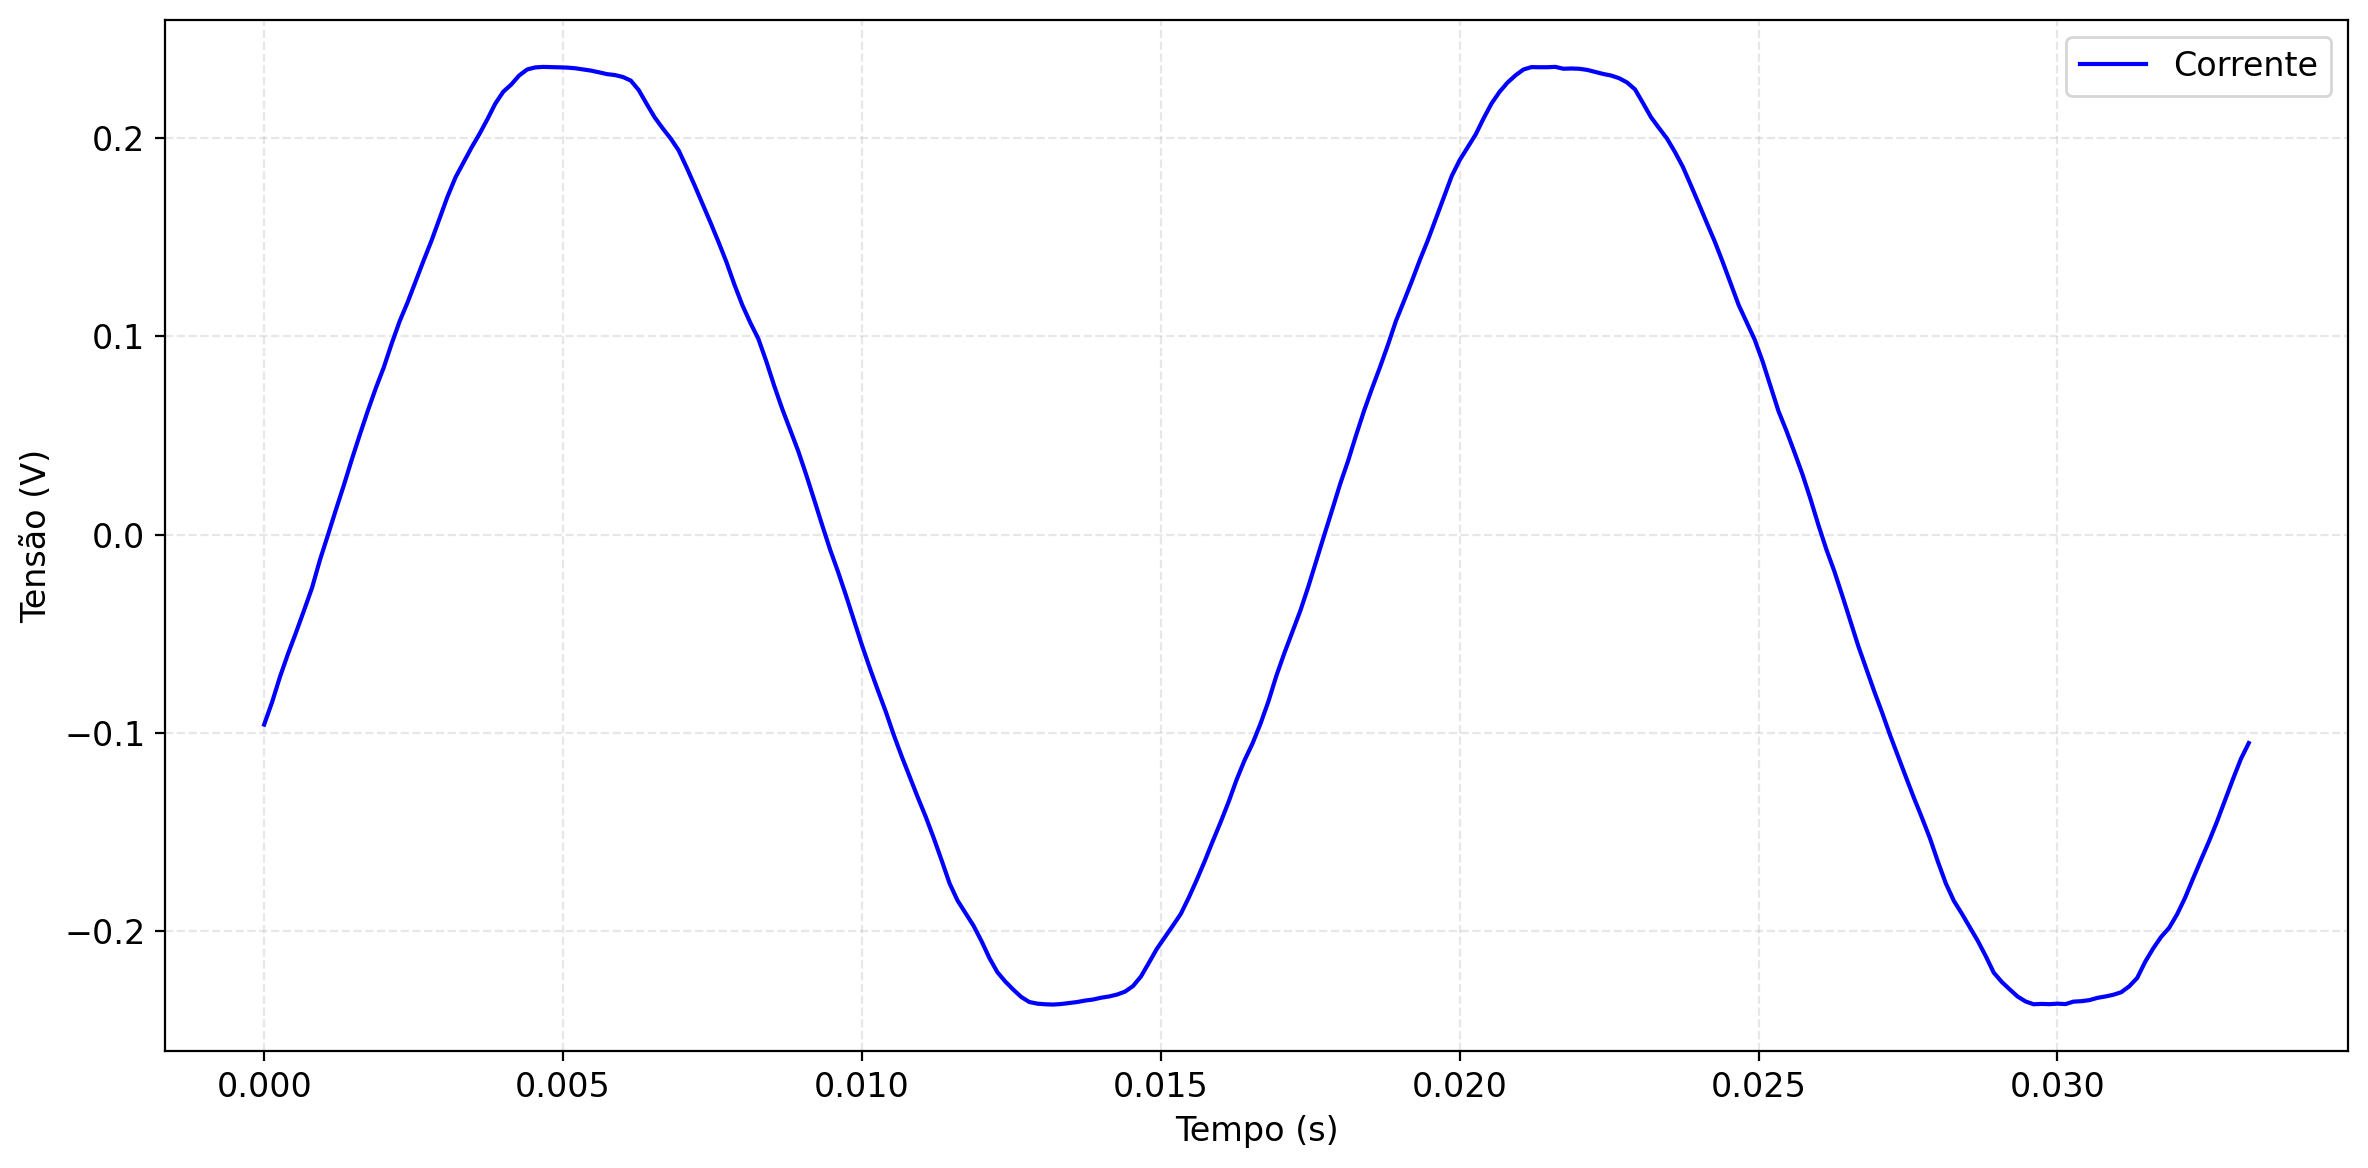

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# --- CONFIGURAÇÃO GLOBAL PARA ALTA QUALIDADE DE PLOTAGEM ---
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# --- 1. CARREGAMENTO E LIMPEZA DOS DADOS ---
caminho_arquivo = "/content/dados_tempo_lamp.csv"
try:
    df = pd.read_csv(caminho_arquivo, delimiter=",", skiprows=1, names=["Tempo (s)", "Corrente (A)"])
except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado.")
    exit()

df["Tempo (s)"] = pd.to_numeric(df["Tempo (s)"], errors="coerce")
df["Corrente (A)"] = pd.to_numeric(df["Corrente (A)"], errors="coerce")
df = df.dropna().sort_values(by="Tempo (s)")

# --- 2. PREPARAÇÃO PARA ANÁLISE ---
t = df["Tempo (s)"].values
y = df["Corrente (A)"].values

if len(y) < 2:
    print("Não há dados suficientes para analisar após a limpeza.")
else:
    # --- 3. CÁLCULO DOS PARÂMETROS DE AMOSTRAGEM E FFT ---
    N = len(y)
    Ts = np.mean(np.diff(t))
    fs = 1 / Ts

    yf_complex = fft(y)
    xf = fftfreq(N, Ts)

    xf_pos = xf[:N // 2]
    yf_mag = 2.0 / N * np.abs(yf_complex[:N // 2])

    # --- 4. DETECÇÃO DA FREQUÊNCIA FUNDAMENTAL ---
    if len(yf_mag) > 1:
        indice_pico = np.argmax(yf_mag[1:]) + 1
        freq_fund = xf_pos[indice_pico]
    else:
        freq_fund = 0

    # --- 5. PLOTAGEM EM FIGURAS SEPARADAS DE ALTA QUALIDADE ---

# Gráfico 1: Sinal Original no Domínio do Tempo
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(t, y, label="Sinal", color="blue", linewidth=1.5)
plt.title("Sinal Original no Domínio do Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Corrente (A)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Espectro de Frequência (FFT)
plt.figure(figsize=(12, 6), dpi=200)  # Tamanho consistente
plt.plot(xf_pos, yf_mag, label="FFT do Sinal", color="green", linewidth=1.5)
plt.axvline(x=60, color='blue', linestyle='--', alpha=0.69, label='60 Hz (marcador)')
plt.xlim(0, 3750)  # Ajusta o limite superior do eixo x para 3750 Hz

# Define os "ticks" do eixo X para incluir 3750 Hz
plt.xticks(np.arange(0, 3751, 250))  # Ajuste os valores conforme necessário

plt.title("")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 3: Zoom em 2 Períodos
if freq_fund > 0:
    print(f"Frequência fundamental detectada: {freq_fund:.2f} Hz")

    amostras_zoom = int(round(2 * fs / freq_fund))
    if amostras_zoom > N:
        amostras_zoom = N

    plt.figure(figsize=(12, 6), dpi=200)  # Tamanho consistente
    plt.plot(t[:amostras_zoom], y[:amostras_zoom], label="Corrente", color="blue", linewidth=1.5)
    plt.title(f"")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Tensão (V)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível detectar uma frequência fundamental válida para o zoom.")
    plt.figure(figsize=(12, 6), dpi=200)  # Tamanho consistente
    plt.text(0.5, 0.5, 'Zoom não aplicável (frequência fundamental não detectada)',
             ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# **Notebook - Osciloscópio**

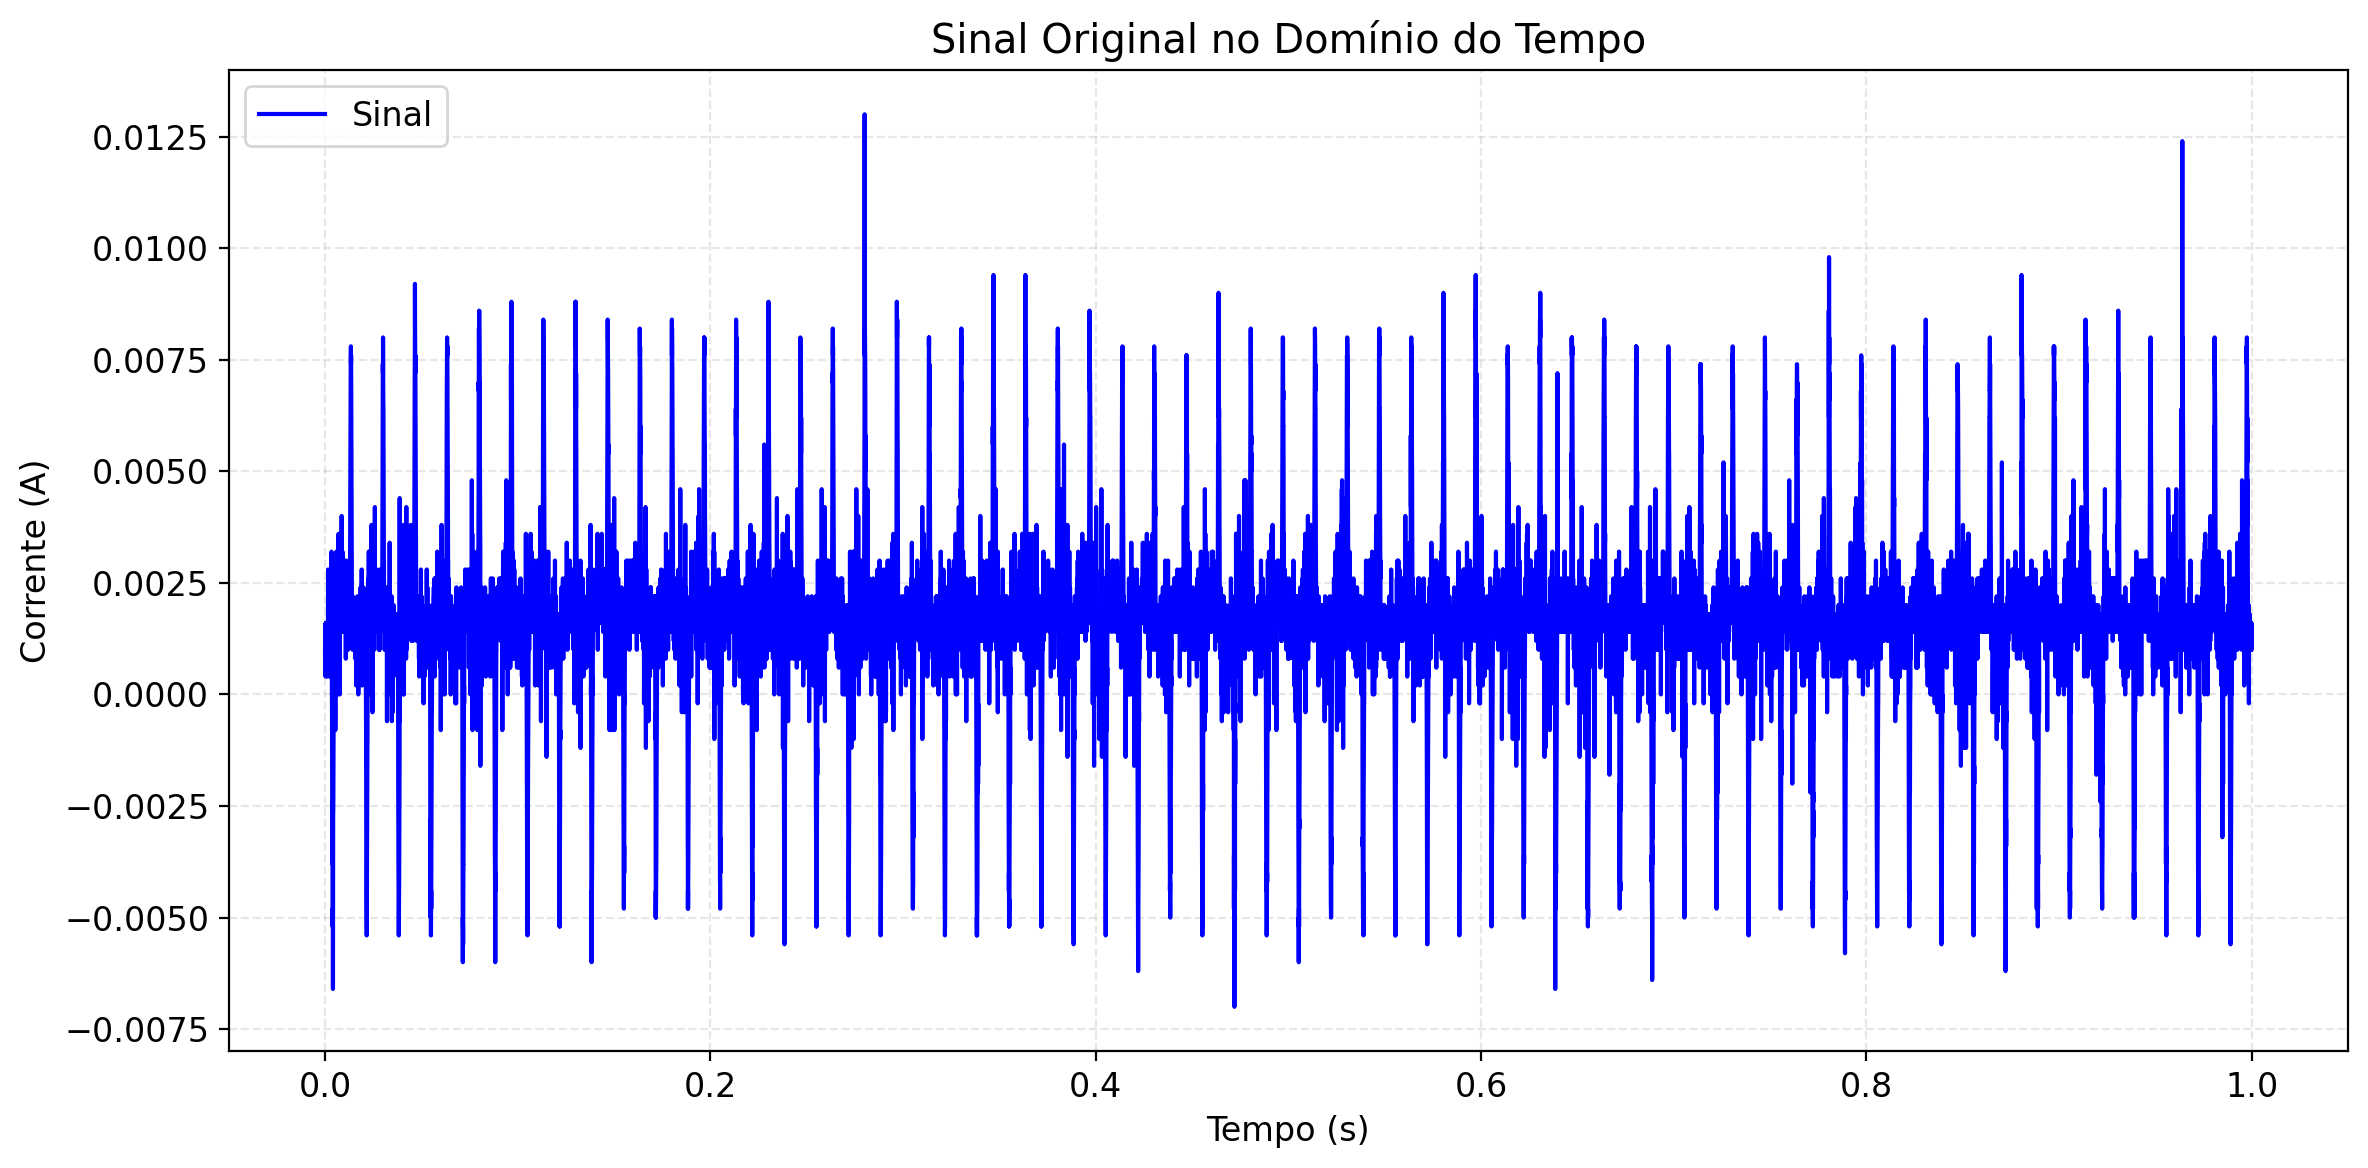

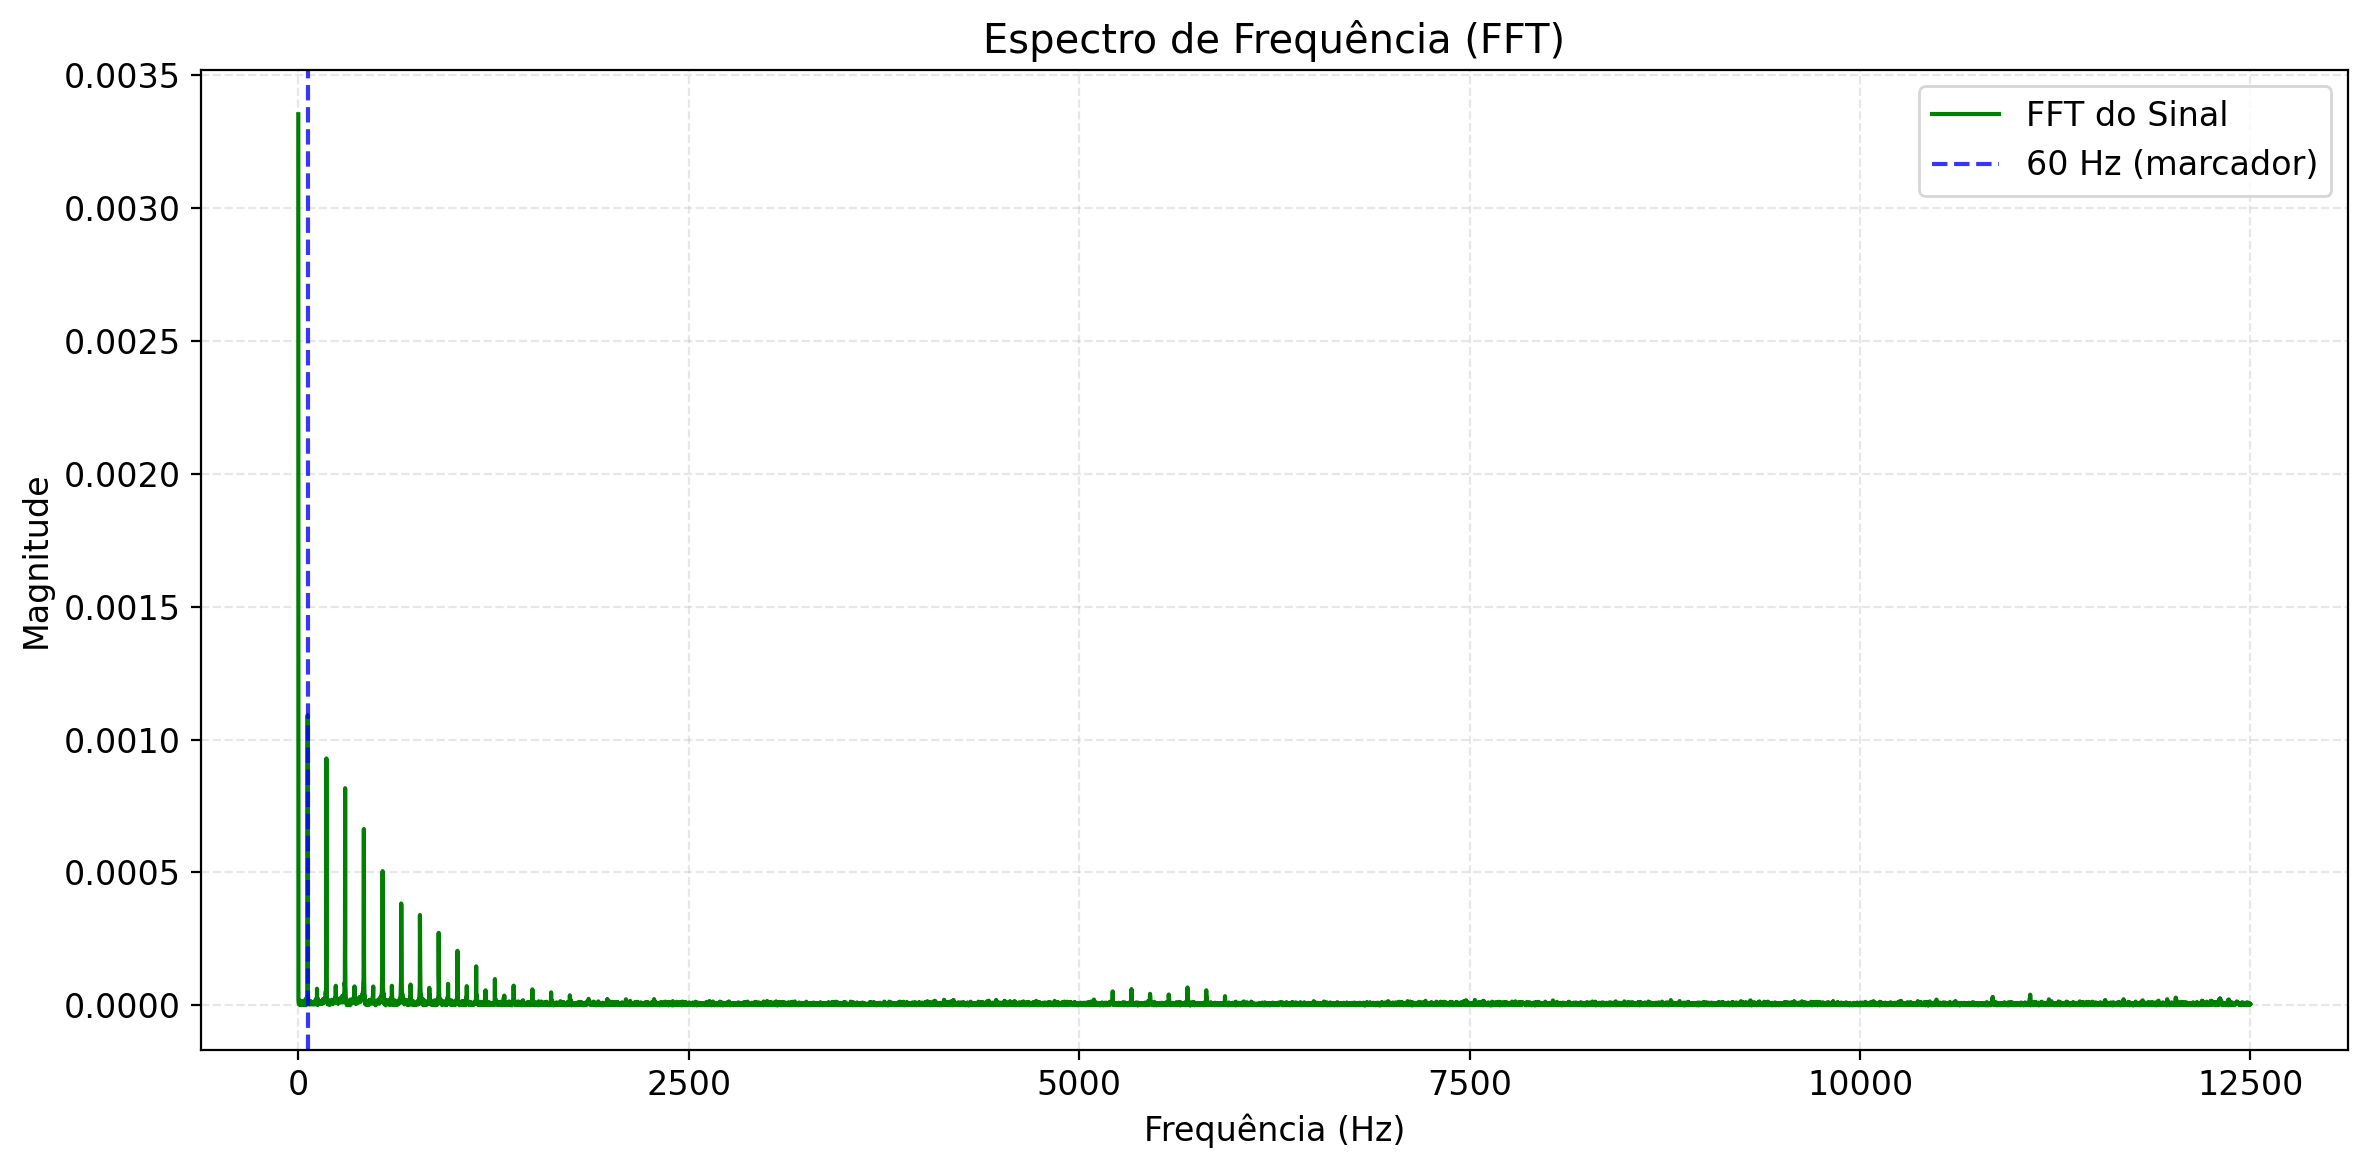

Frequência fundamental detectada: 60.00 Hz


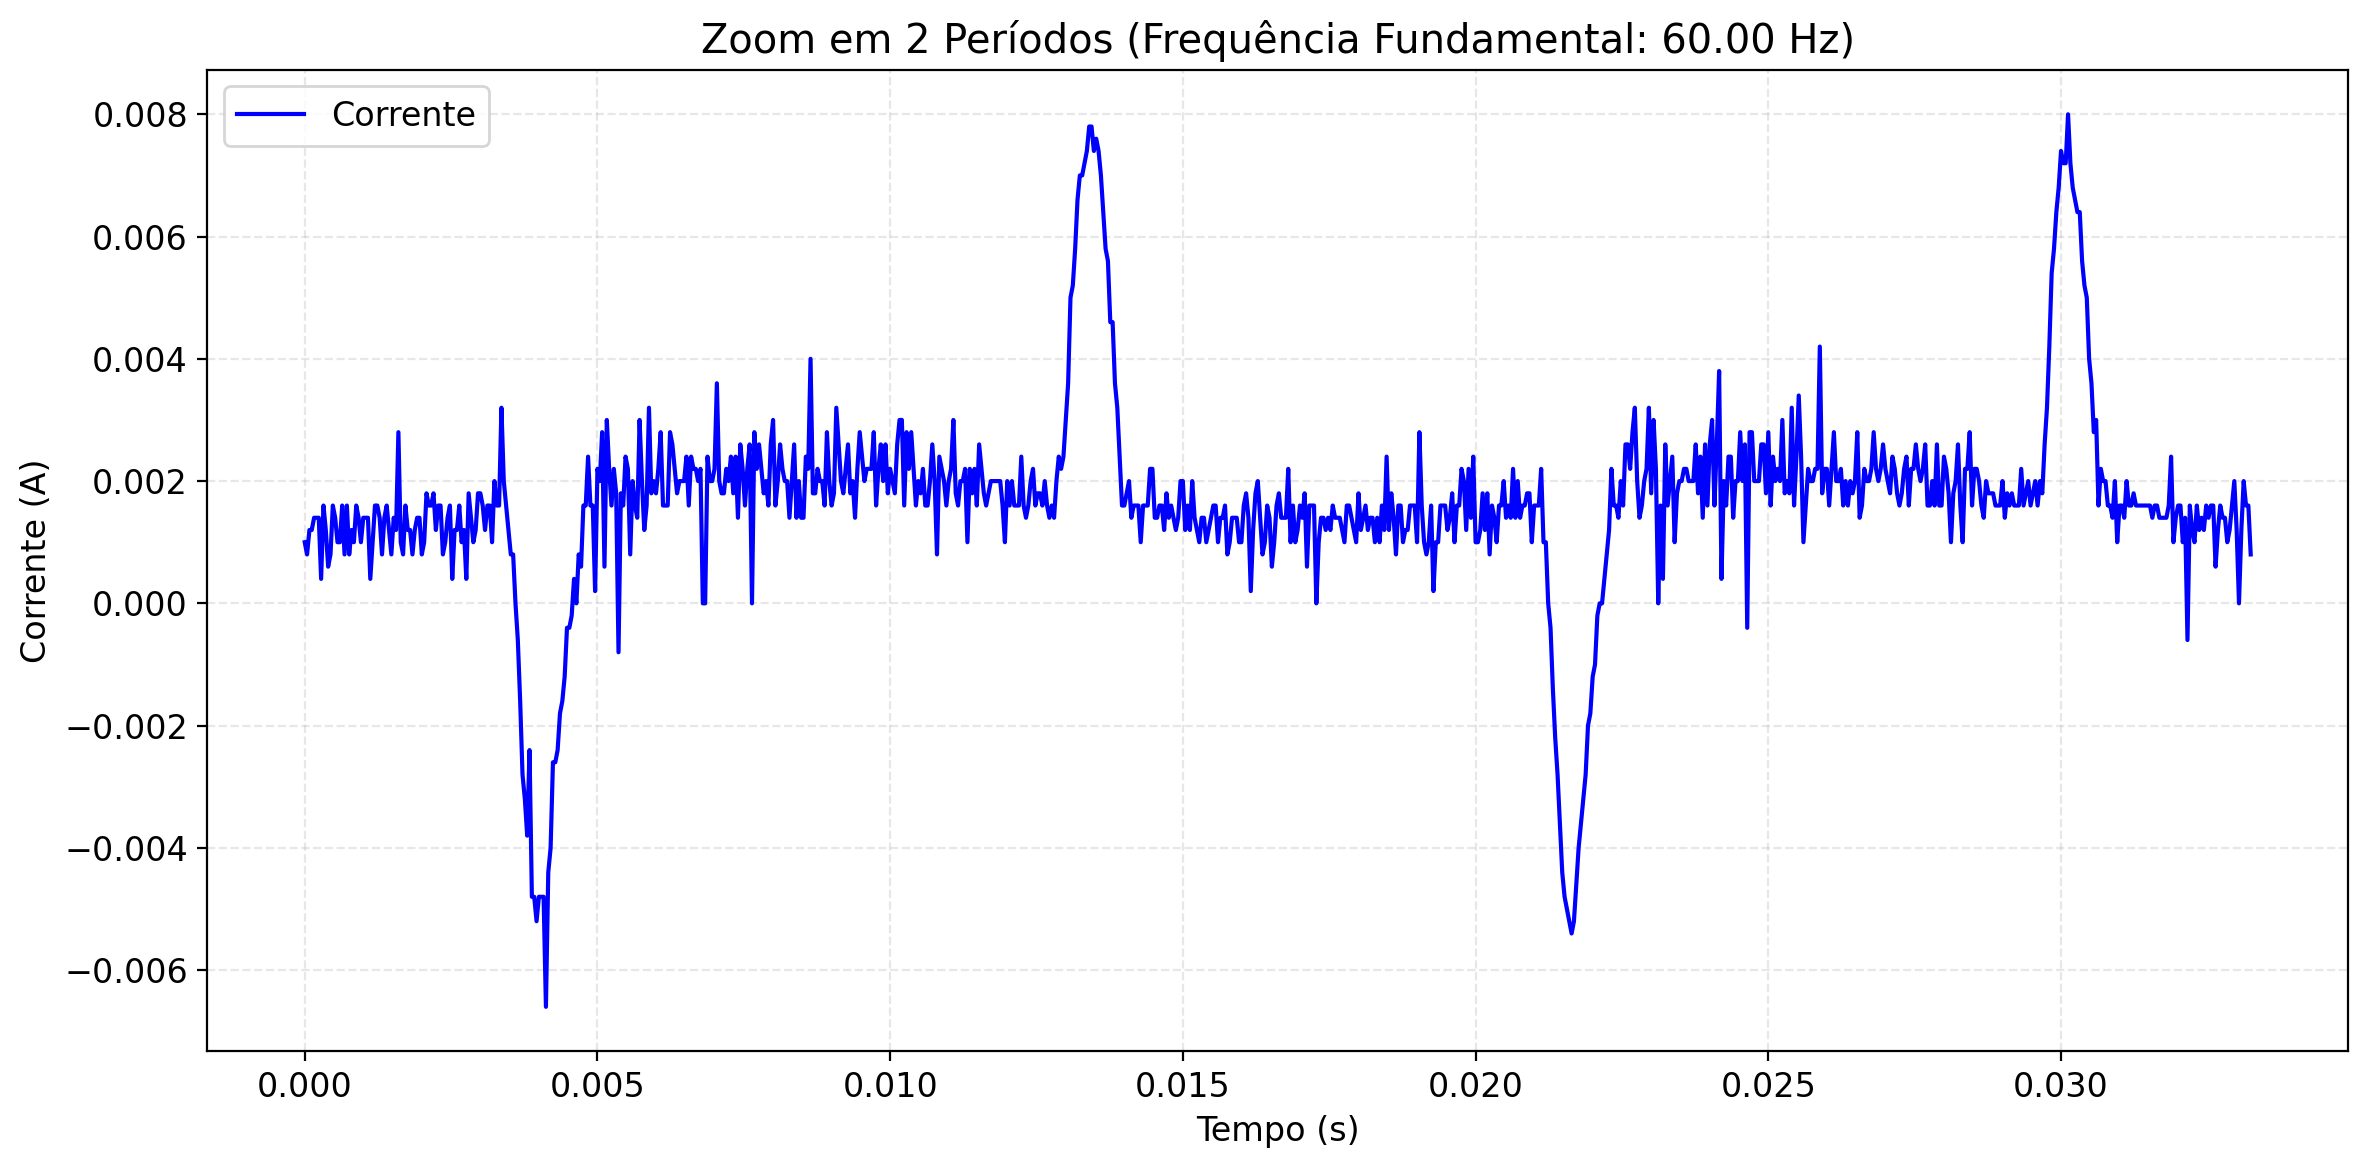

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# --- CONFIGURAÇÃO GLOBAL PARA ALTA QUALIDADE DE PLOTAGEM ---
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# --- 1. CARREGAMENTO E LIMPEZA DOS DADOS ---
caminho_arquivo = "/content/N.CSV"
try:
    df = pd.read_csv(caminho_arquivo, delimiter=",", skiprows=1, names=["Tempo (s)", "Corrente (A)"])
except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado.")
    exit()

df["Tempo (s)"] = pd.to_numeric(df["Tempo (s)"], errors="coerce")
df["Corrente (A)"] = pd.to_numeric(df["Corrente (A)"], errors="coerce")
df = df.dropna().sort_values(by="Tempo (s)")

# --- 2. PREPARAÇÃO PARA ANÁLISE ---
t = df["Tempo (s)"].values
y = df["Corrente (A)"].values

# Ajuste para o gráfico do tempo, começando de 0 se os valores estiverem negativos
t = t - t[0]

# Limitar o sinal a 1 segundo
t_limitado = t[t <= 1]  # Limitar até 1 segundo
y_limitado = y[:len(t_limitado)]  # Manter apenas os dados correspondentes

if len(y_limitado) < 2:
    print("Não há dados suficientes para analisar após a limpeza.")
else:
    # --- 3. CÁLCULO DOS PARÂMETROS DE AMOSTRAGEM E FFT ---
    N = len(y_limitado)
    Ts = np.mean(np.diff(t_limitado))
    fs = 1 / Ts

    yf_complex = fft(y_limitado)
    xf = fftfreq(N, Ts)

    # Limitar a frequência máxima para o gráfico (Nyquist)
    xf_pos = xf[:N // 2]
    yf_mag = 2.0 / N * np.abs(yf_complex[:N // 2])

    # --- 4. DETECÇÃO DA FREQUÊNCIA FUNDAMENTAL ---
    if len(yf_mag) > 1:
        indice_pico = np.argmax(yf_mag[1:]) + 1
        freq_fund = xf_pos[indice_pico]
    else:
        freq_fund = 0

    # --- 5. PLOTAGEM EM FIGURAS SEPARADAS DE ALTA QUALIDADE ---

    # Gráfico 1: Sinal Original no Domínio do Tempo
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(t_limitado, y_limitado, label="Sinal", color="blue", linewidth=1.5)
    plt.title("Sinal Original no Domínio do Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Corrente (A)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Espectro de Frequência (FFT)
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(xf_pos, yf_mag, label="FFT do Sinal", color="green", linewidth=1.5)
    plt.axvline(x=60, color='blue', linestyle='--', alpha=0.79, label='60 Hz (marcador)')
    plt.title("Espectro de Frequência (FFT)")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Definir os ticks no eixo X (frequência)
    xticks = np.arange(0, max(xf_pos), step=2500)  # Ajuste o intervalo conforme necessário
    xticks = np.append(xticks, 12500)  # Adiciona 12500 no final
    plt.xticks(xticks)

    plt.tight_layout()
    plt.show()


    # Gráfico 3: Zoom em 2 Períodos
    if freq_fund > 0:
        print(f"Frequência fundamental detectada: {freq_fund:.2f} Hz")

        amostras_zoom = int(round(2 * fs / freq_fund))
        if amostras_zoom > N:
            amostras_zoom = N

        plt.figure(figsize=(12, 6), dpi=200)
        plt.plot(t_limitado[:amostras_zoom], y_limitado[:amostras_zoom], label="Corrente", color="blue", linewidth=1.5)
        plt.title(f"Zoom em 2 Períodos (Frequência Fundamental: {freq_fund:.2f} Hz)")
        plt.xlabel("Tempo (s)")
        plt.ylabel("Corrente (A)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Não foi possível detectar uma frequência fundamental válida para o zoom.")
        plt.figure(figsize=(12, 3), dpi=200)
        plt.text(0.5, 0.5, 'Zoom não aplicável (frequência fundamental não detectada)',
                 ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# **Notebook - Sistema Proposto**

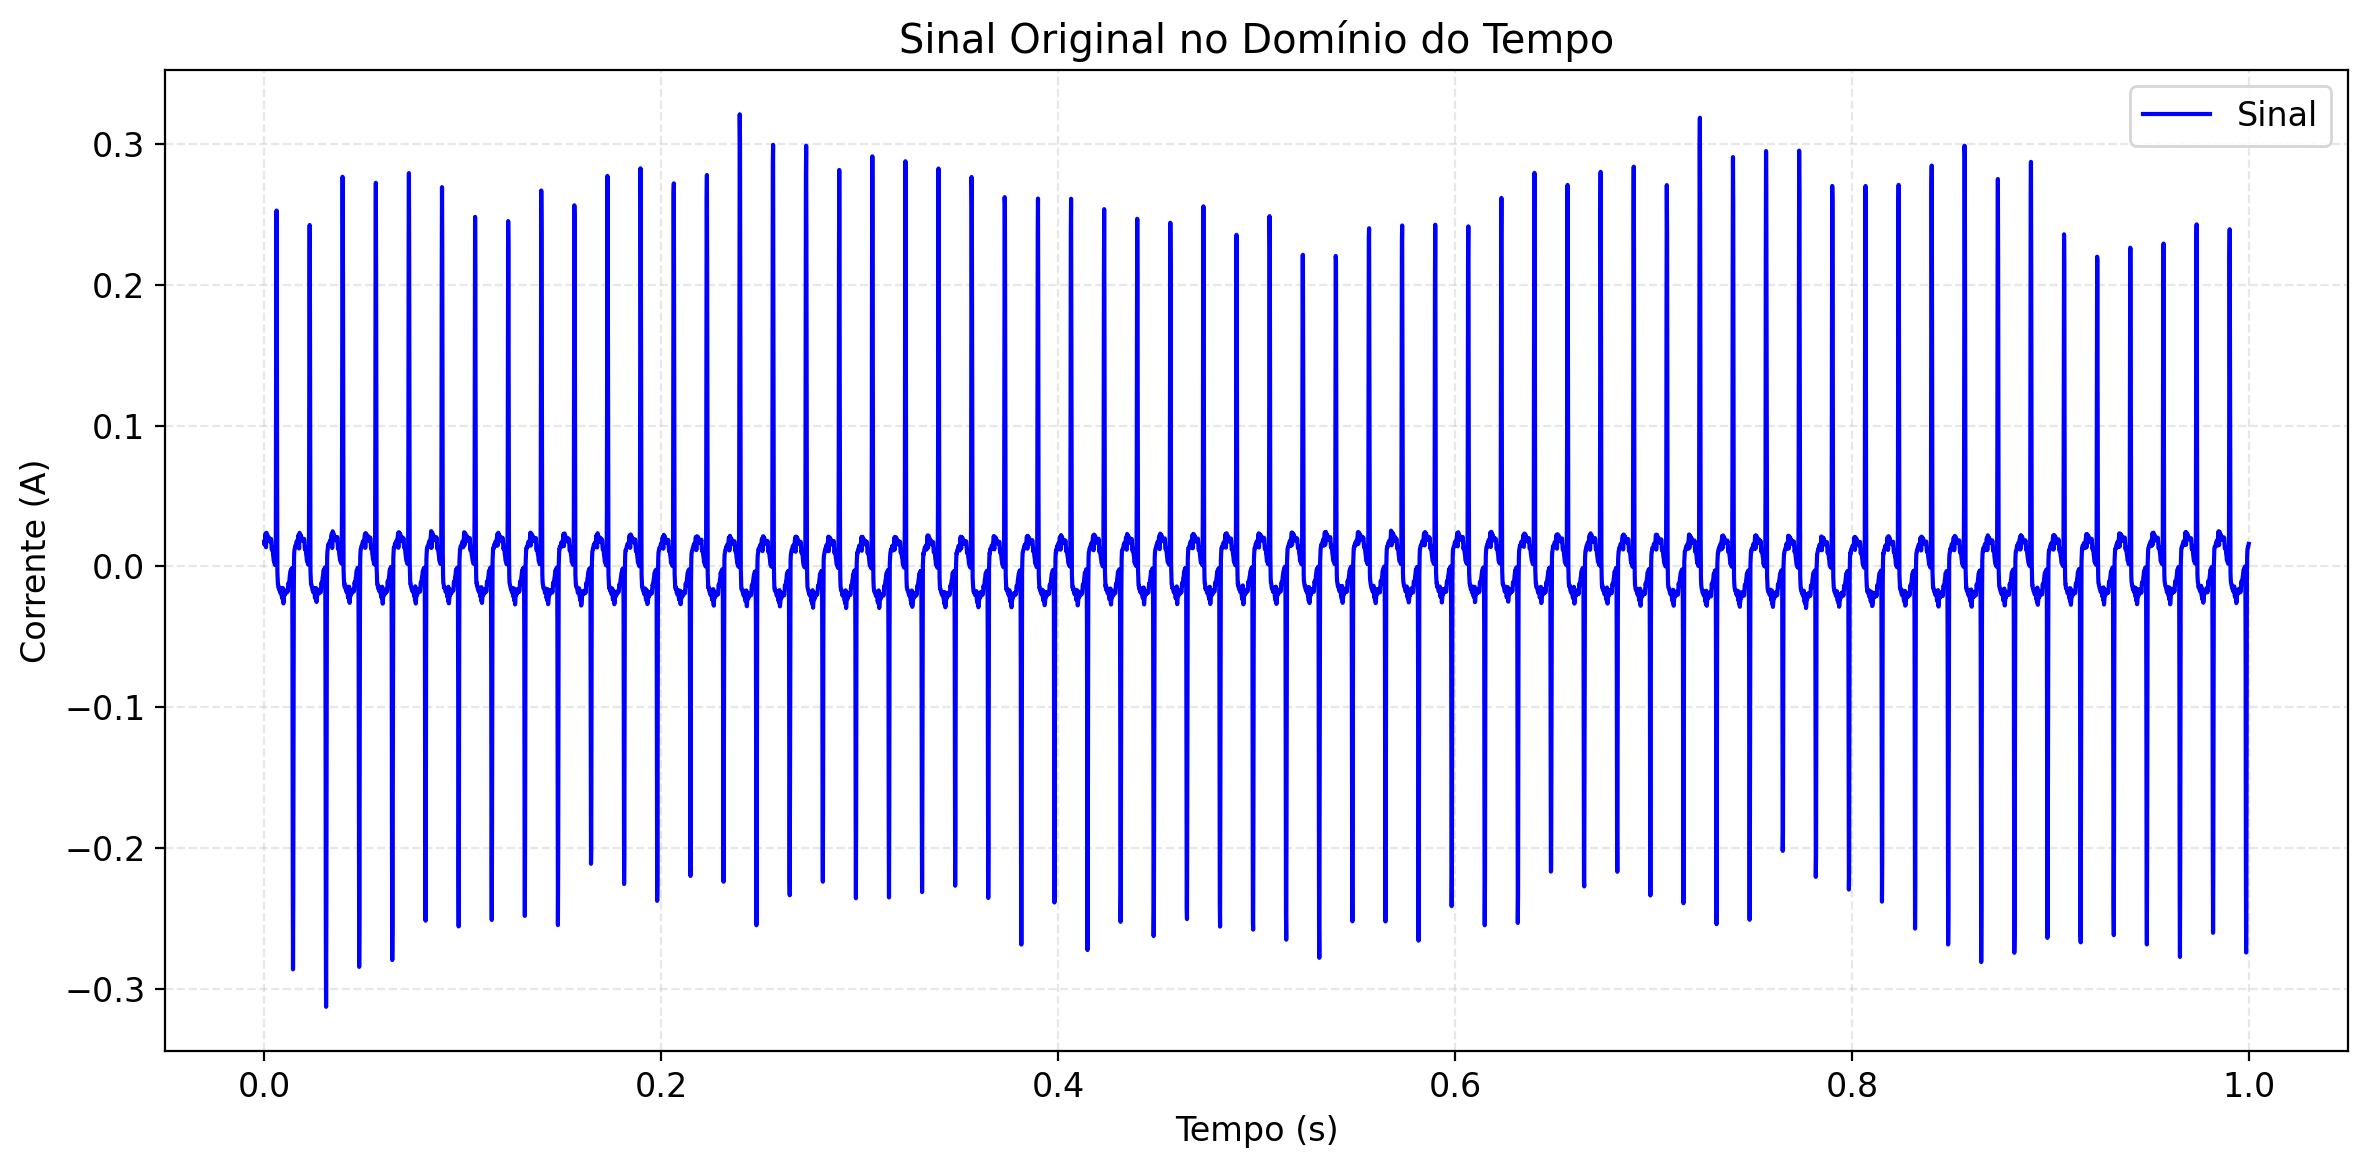

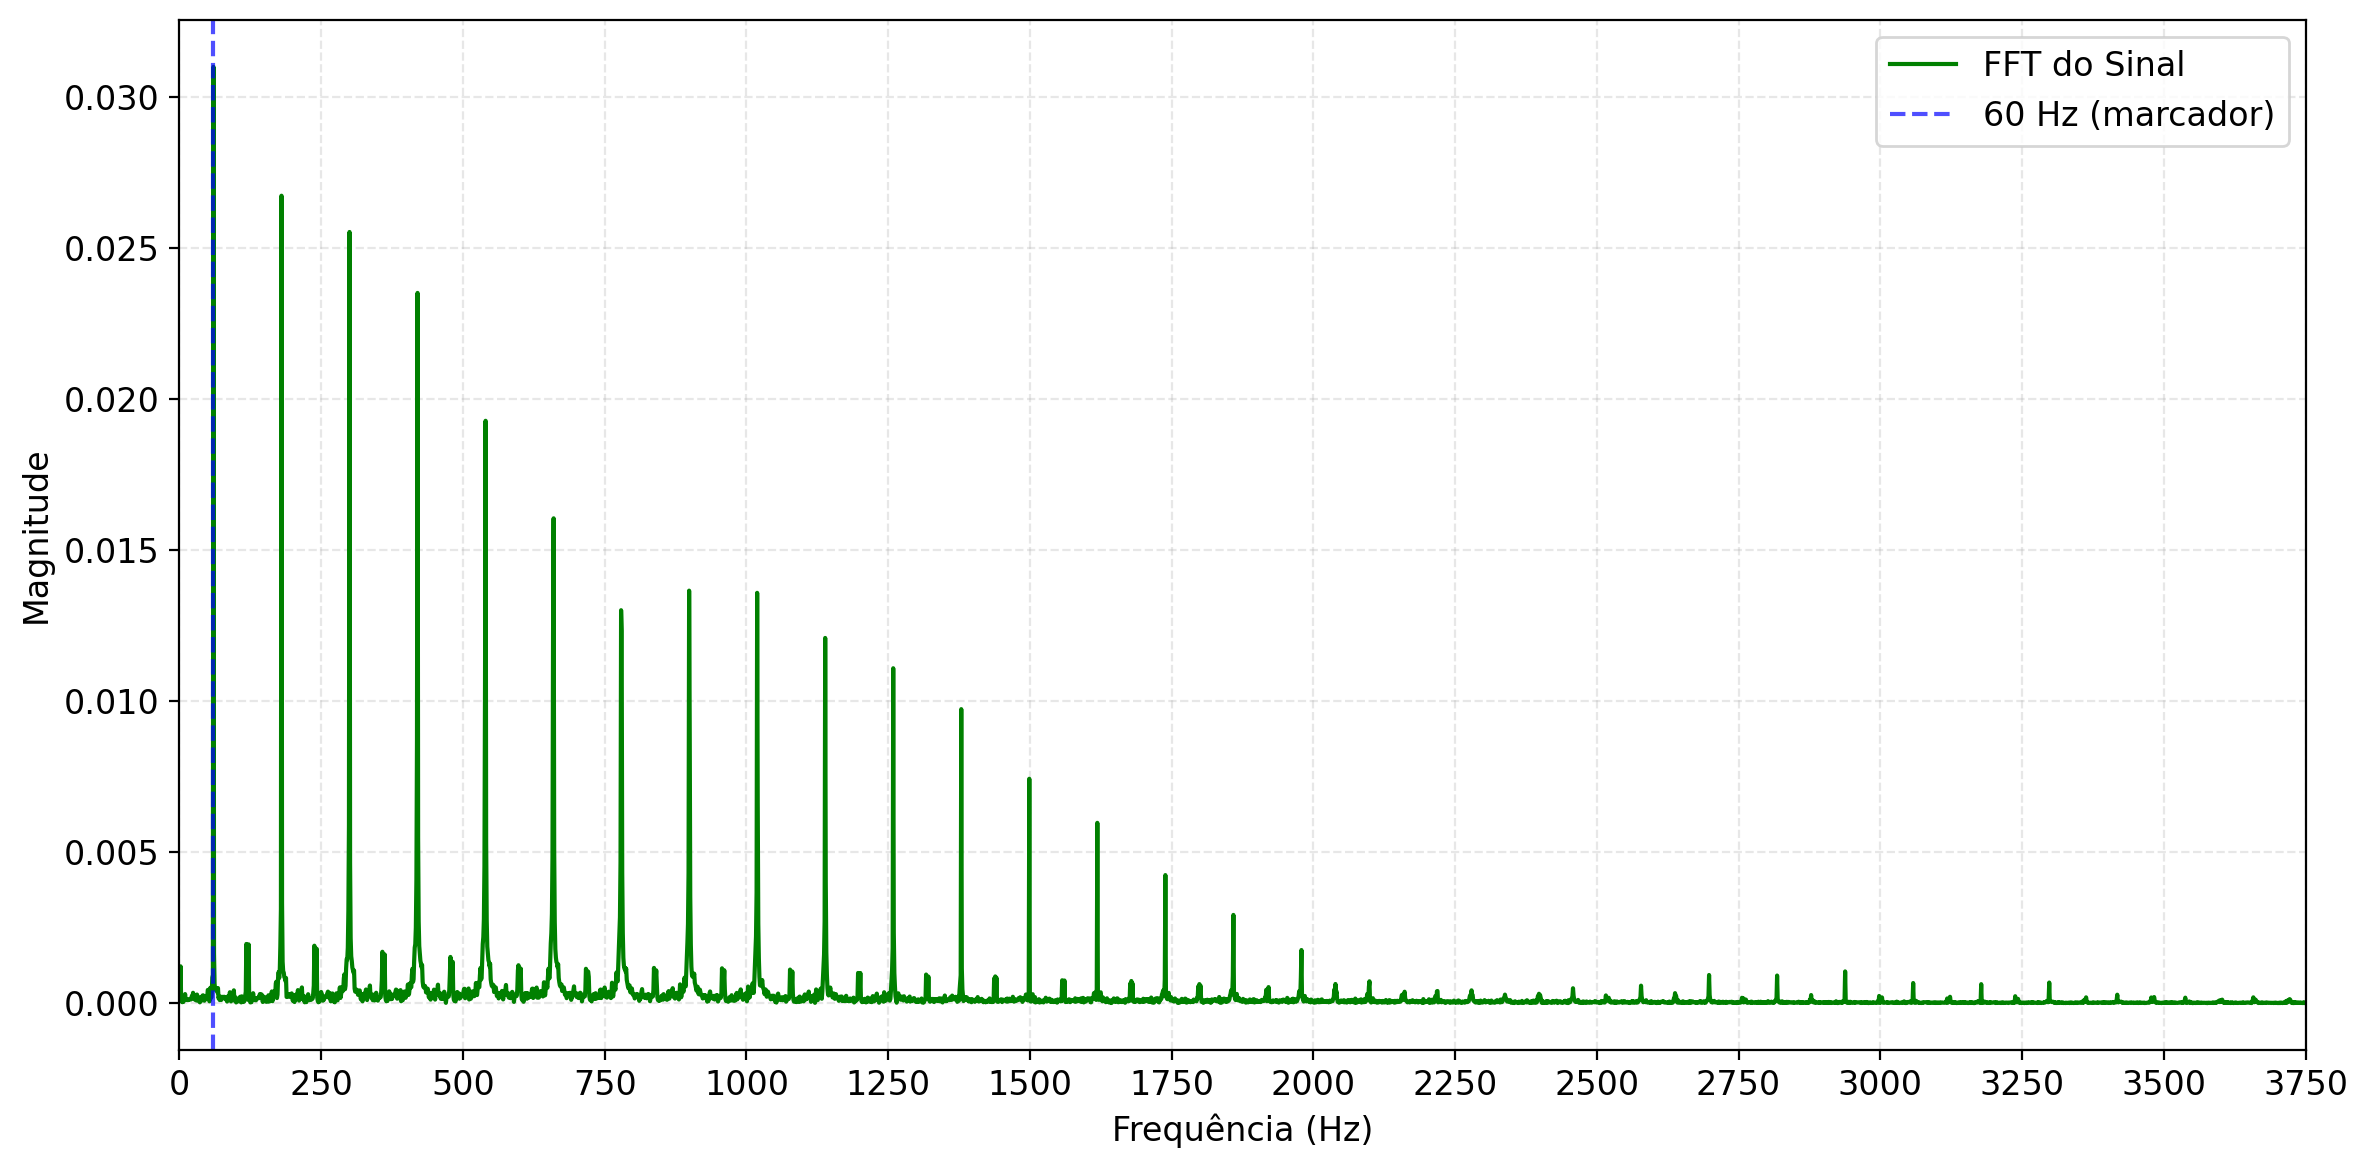

Frequência fundamental detectada: 60.00 Hz


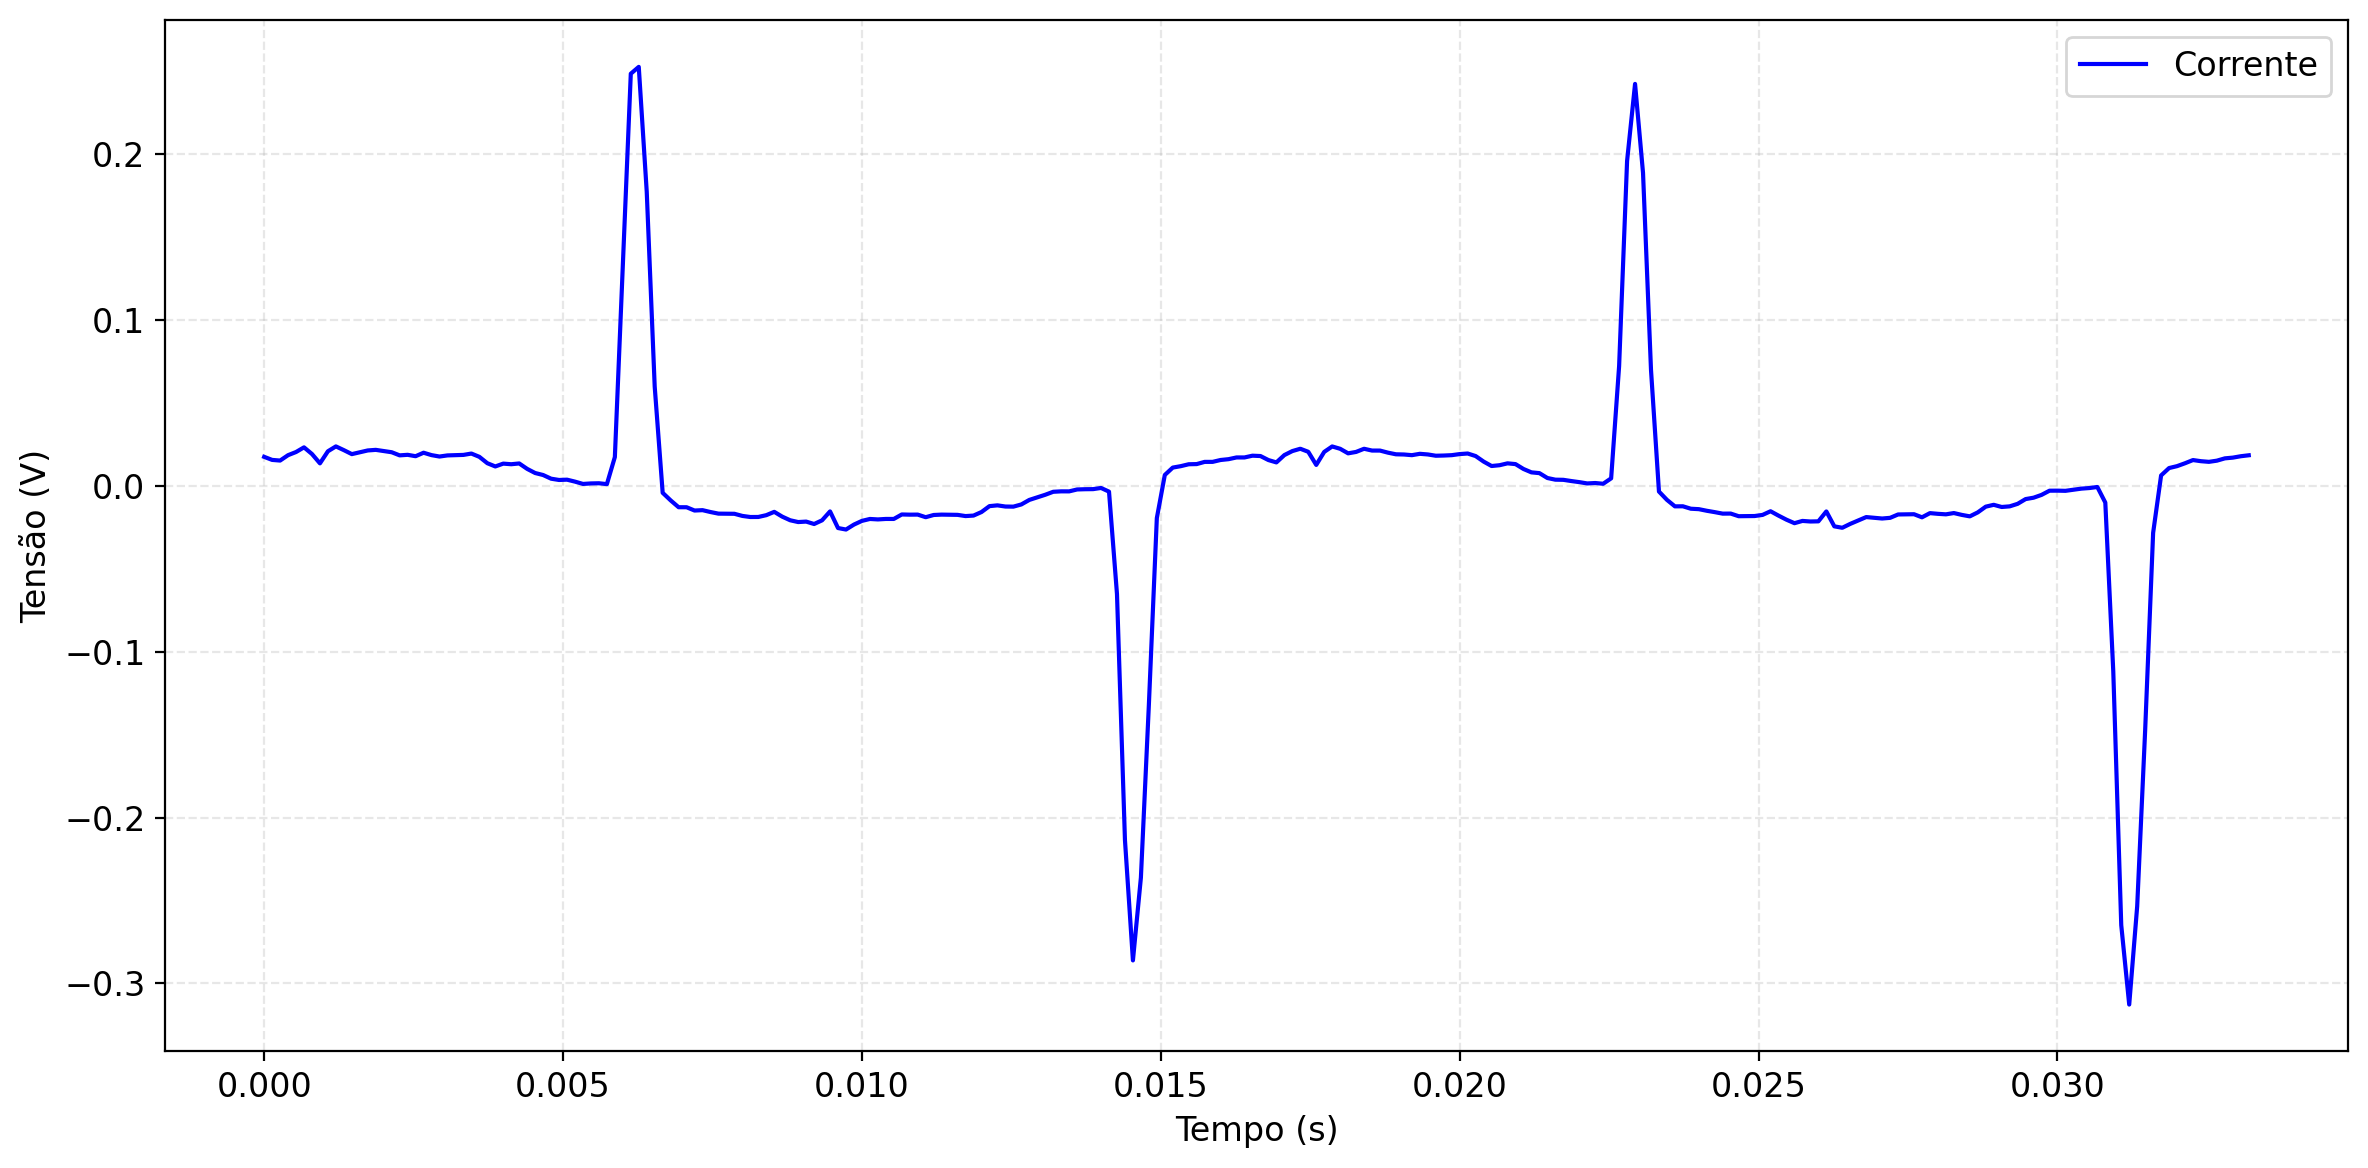

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# --- CONFIGURAÇÃO GLOBAL PARA ALTA QUALIDADE DE PLOTAGEM ---
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# --- 1. CARREGAMENTO E LIMPEZA DOS DADOS ---
caminho_arquivo = "/content/dados_tempo.csv"
try:
    df = pd.read_csv(caminho_arquivo, delimiter=",", skiprows=1, names=["Tempo (s)", "Corrente (A)"])
except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado.")
    exit()

df["Tempo (s)"] = pd.to_numeric(df["Tempo (s)"], errors="coerce")
df["Corrente (A)"] = pd.to_numeric(df["Corrente (A)"], errors="coerce")
df = df.dropna().sort_values(by="Tempo (s)")

# --- 2. PREPARAÇÃO PARA ANÁLISE ---
t = df["Tempo (s)"].values
y = df["Corrente (A)"].values

if len(y) < 2:
    print("Não há dados suficientes para analisar após a limpeza.")
else:
    # --- 3. CÁLCULO DOS PARÂMETROS DE AMOSTRAGEM E FFT ---
    N = len(y)
    Ts = np.mean(np.diff(t))
    fs = 1 / Ts

    yf_complex = fft(y)
    xf = fftfreq(N, Ts)

    xf_pos = xf[:N // 2]
    yf_mag = 2.0 / N * np.abs(yf_complex[:N // 2])

    # --- 4. DETECÇÃO DA FREQUÊNCIA FUNDAMENTAL ---
    if len(yf_mag) > 1:
        indice_pico = np.argmax(yf_mag[1:]) + 1
        freq_fund = xf_pos[indice_pico]
    else:
        freq_fund = 0

    # --- 5. PLOTAGEM EM FIGURAS SEPARADAS DE ALTA QUALIDADE ---

    # Gráfico 1: Sinal Original no Domínio do Tempo
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(t, y, label="Sinal", color="blue", linewidth=1.5)
    plt.title("Sinal Original no Domínio do Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Corrente (A)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Espectro de Frequência (FFT)
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(xf_pos, yf_mag, label="FFT do Sinal", color="green", linewidth=1.5)
    plt.axvline(x=60, color='blue', linestyle='--', alpha=0.69, label='60 Hz (marcador)')
    plt.xlim(0, 3750)  # Ajusta o limite superior do eixo x para 3750 Hz

    # Define os "ticks" do eixo X para incluir 3750 Hz
    plt.xticks(np.arange(0, 3751, 250))  # Ajuste os valores conforme necessário

    plt.title("")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Gráfico 3: Zoom em 2 Períodos
    if freq_fund > 0:
        print(f"Frequência fundamental detectada: {freq_fund:.2f} Hz")

        amostras_zoom = int(round(2 * fs / freq_fund))
        if amostras_zoom > N:
            amostras_zoom = N

        plt.figure(figsize=(12, 6), dpi=200)
        plt.plot(t[:amostras_zoom], y[:amostras_zoom], label="Corrente", color="blue", linewidth=1.5)
        plt.title(f"")
        plt.xlabel("Tempo (s)")
        plt.ylabel("Tensão (V)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Não foi possível detectar uma frequência fundamental válida para o zoom.")
        plt.figure(figsize=(12, 3), dpi=200)
        plt.text(0.5, 0.5, 'Zoom não aplicável (frequência fundamental não detectada)',
                 ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
